In [ ]:
import os
from tools import json_tools, plotting_tools
from hipe4ml.model_handler import ModelHandler
import fasttreeshap as shap
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
json_file_name ="config.json"
model_name = "model_0.0_1.6_positive"
model_dir = f"/Users/julnow/gsi/ml-pid-cbm/ml_pid_cbm/only_tof/mass2/0sigma/{model_name}"
os.chdir(model_dir)
df = pd.read_pickle(f"{model_dir}/validated_data.pickle")


Let's check xgb-selected proton in the first bin, from p =0-1.6 GeV/c

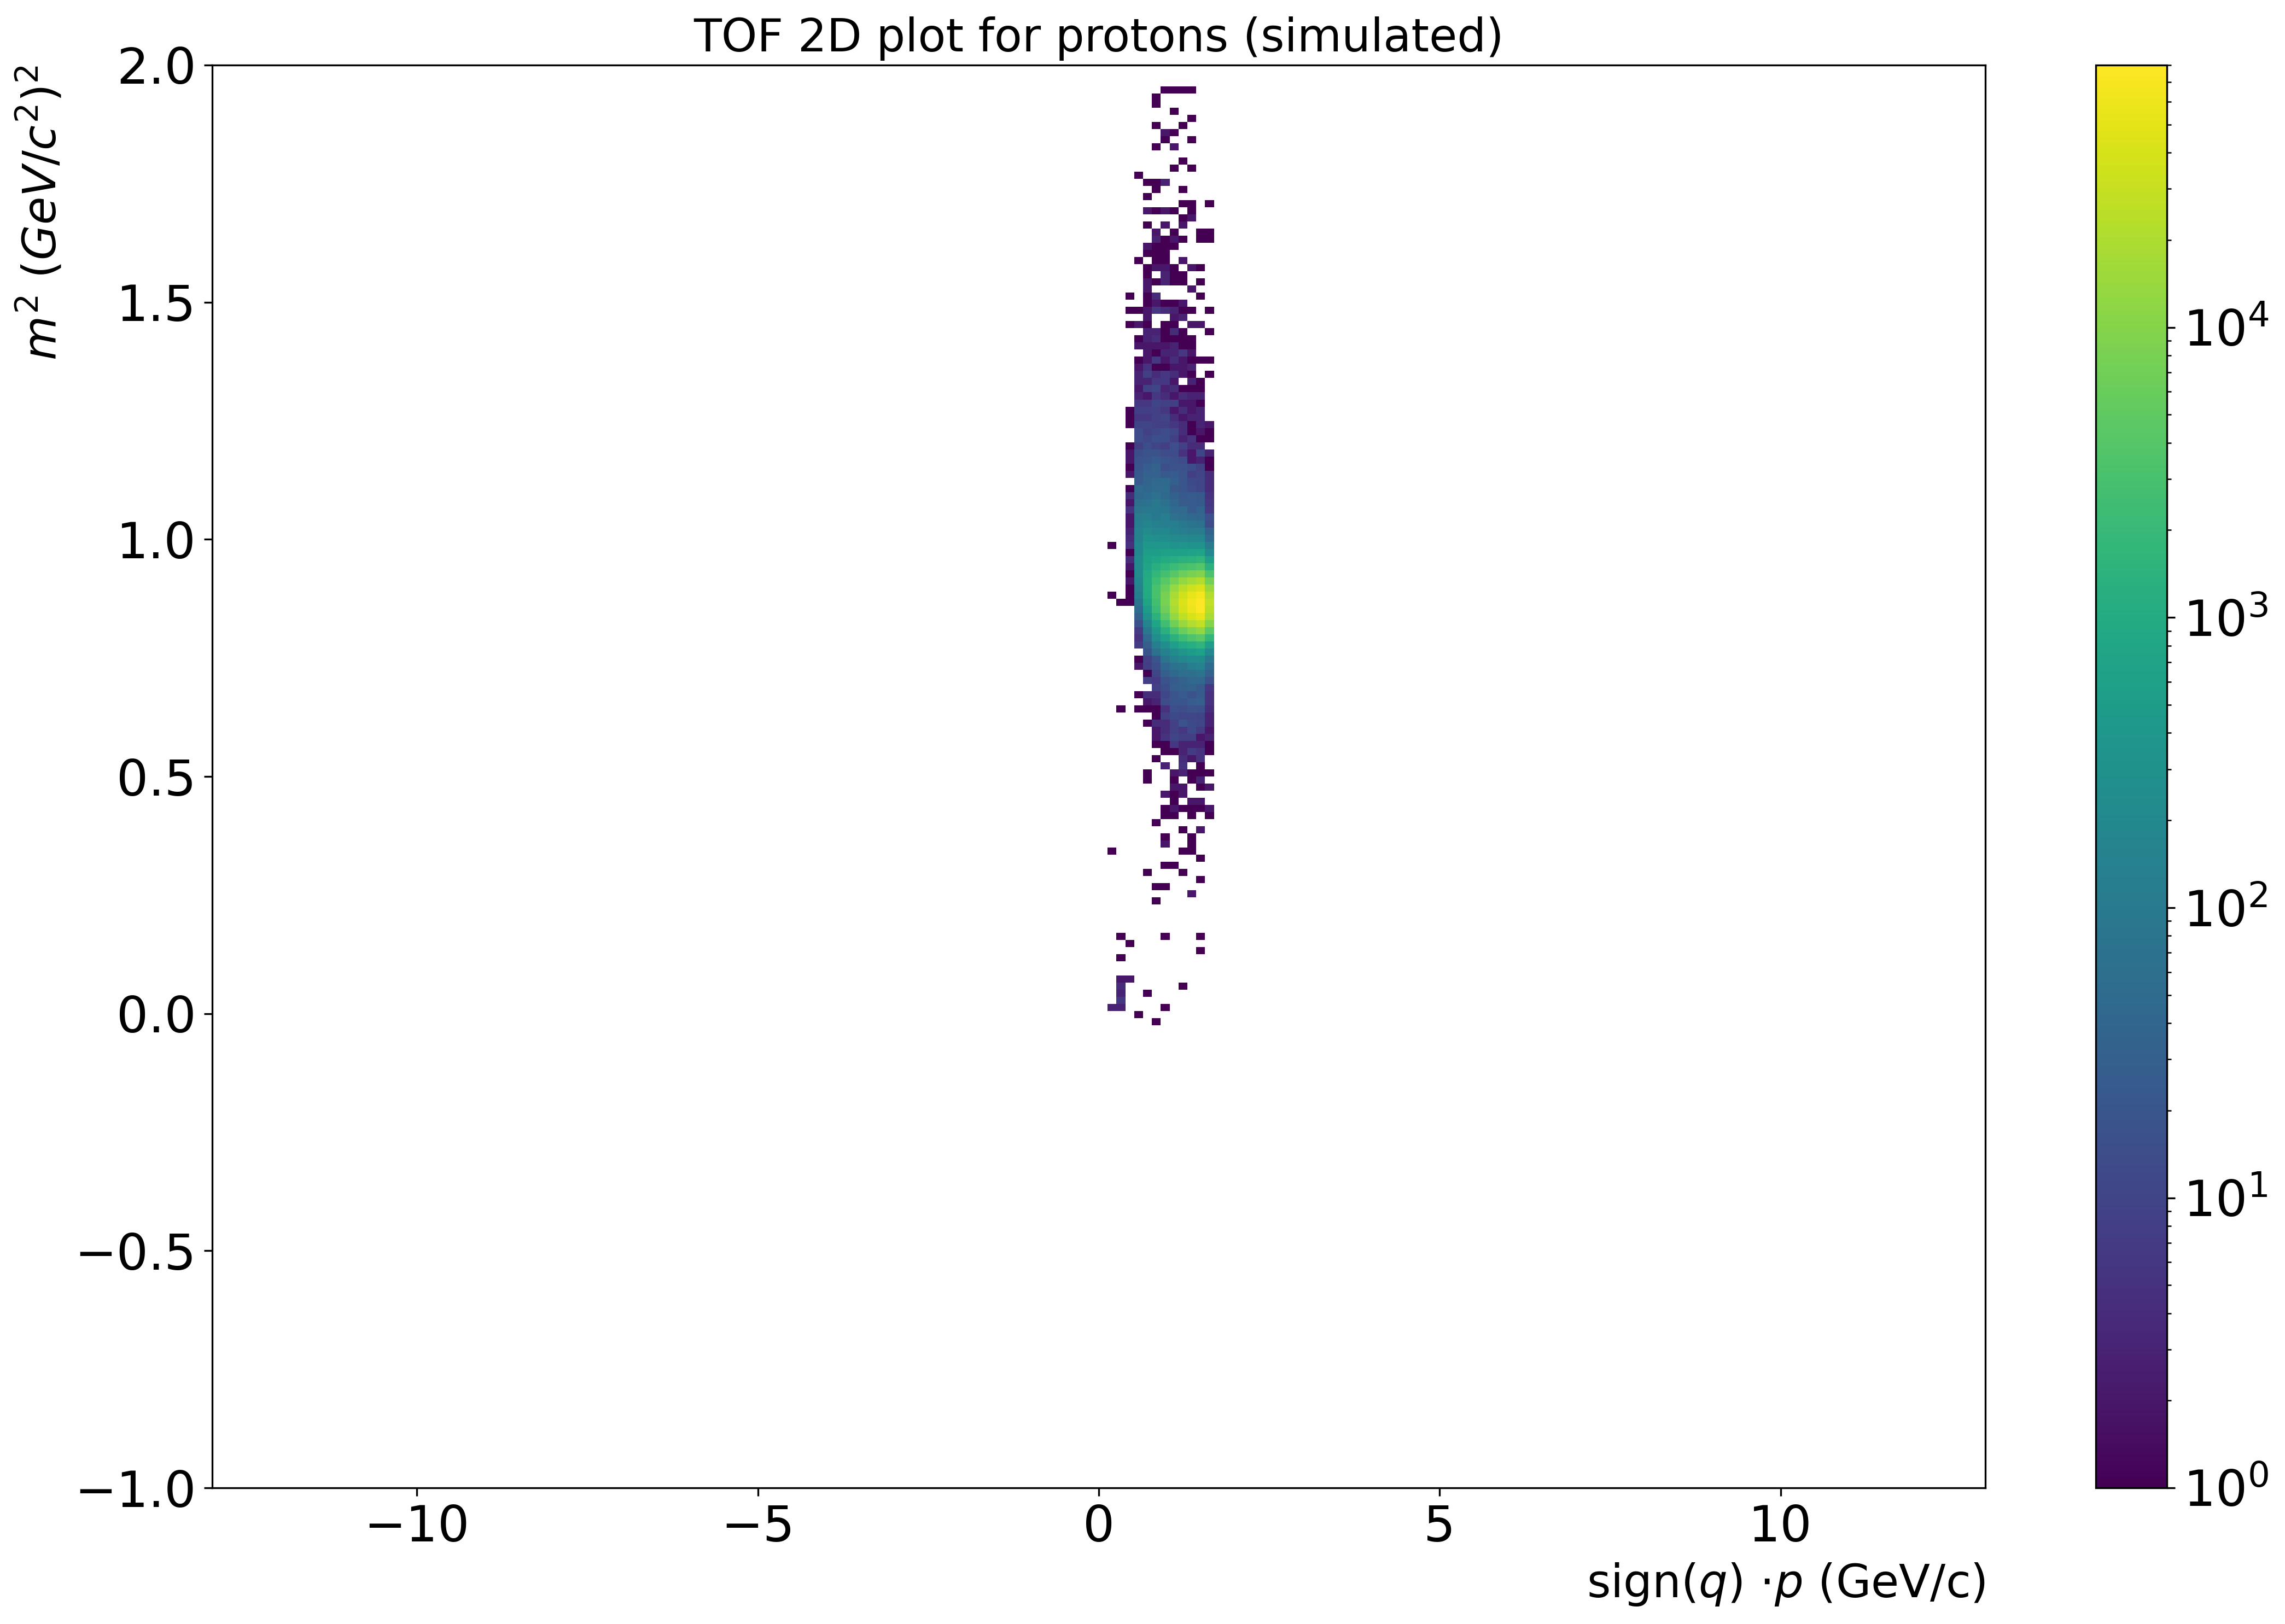

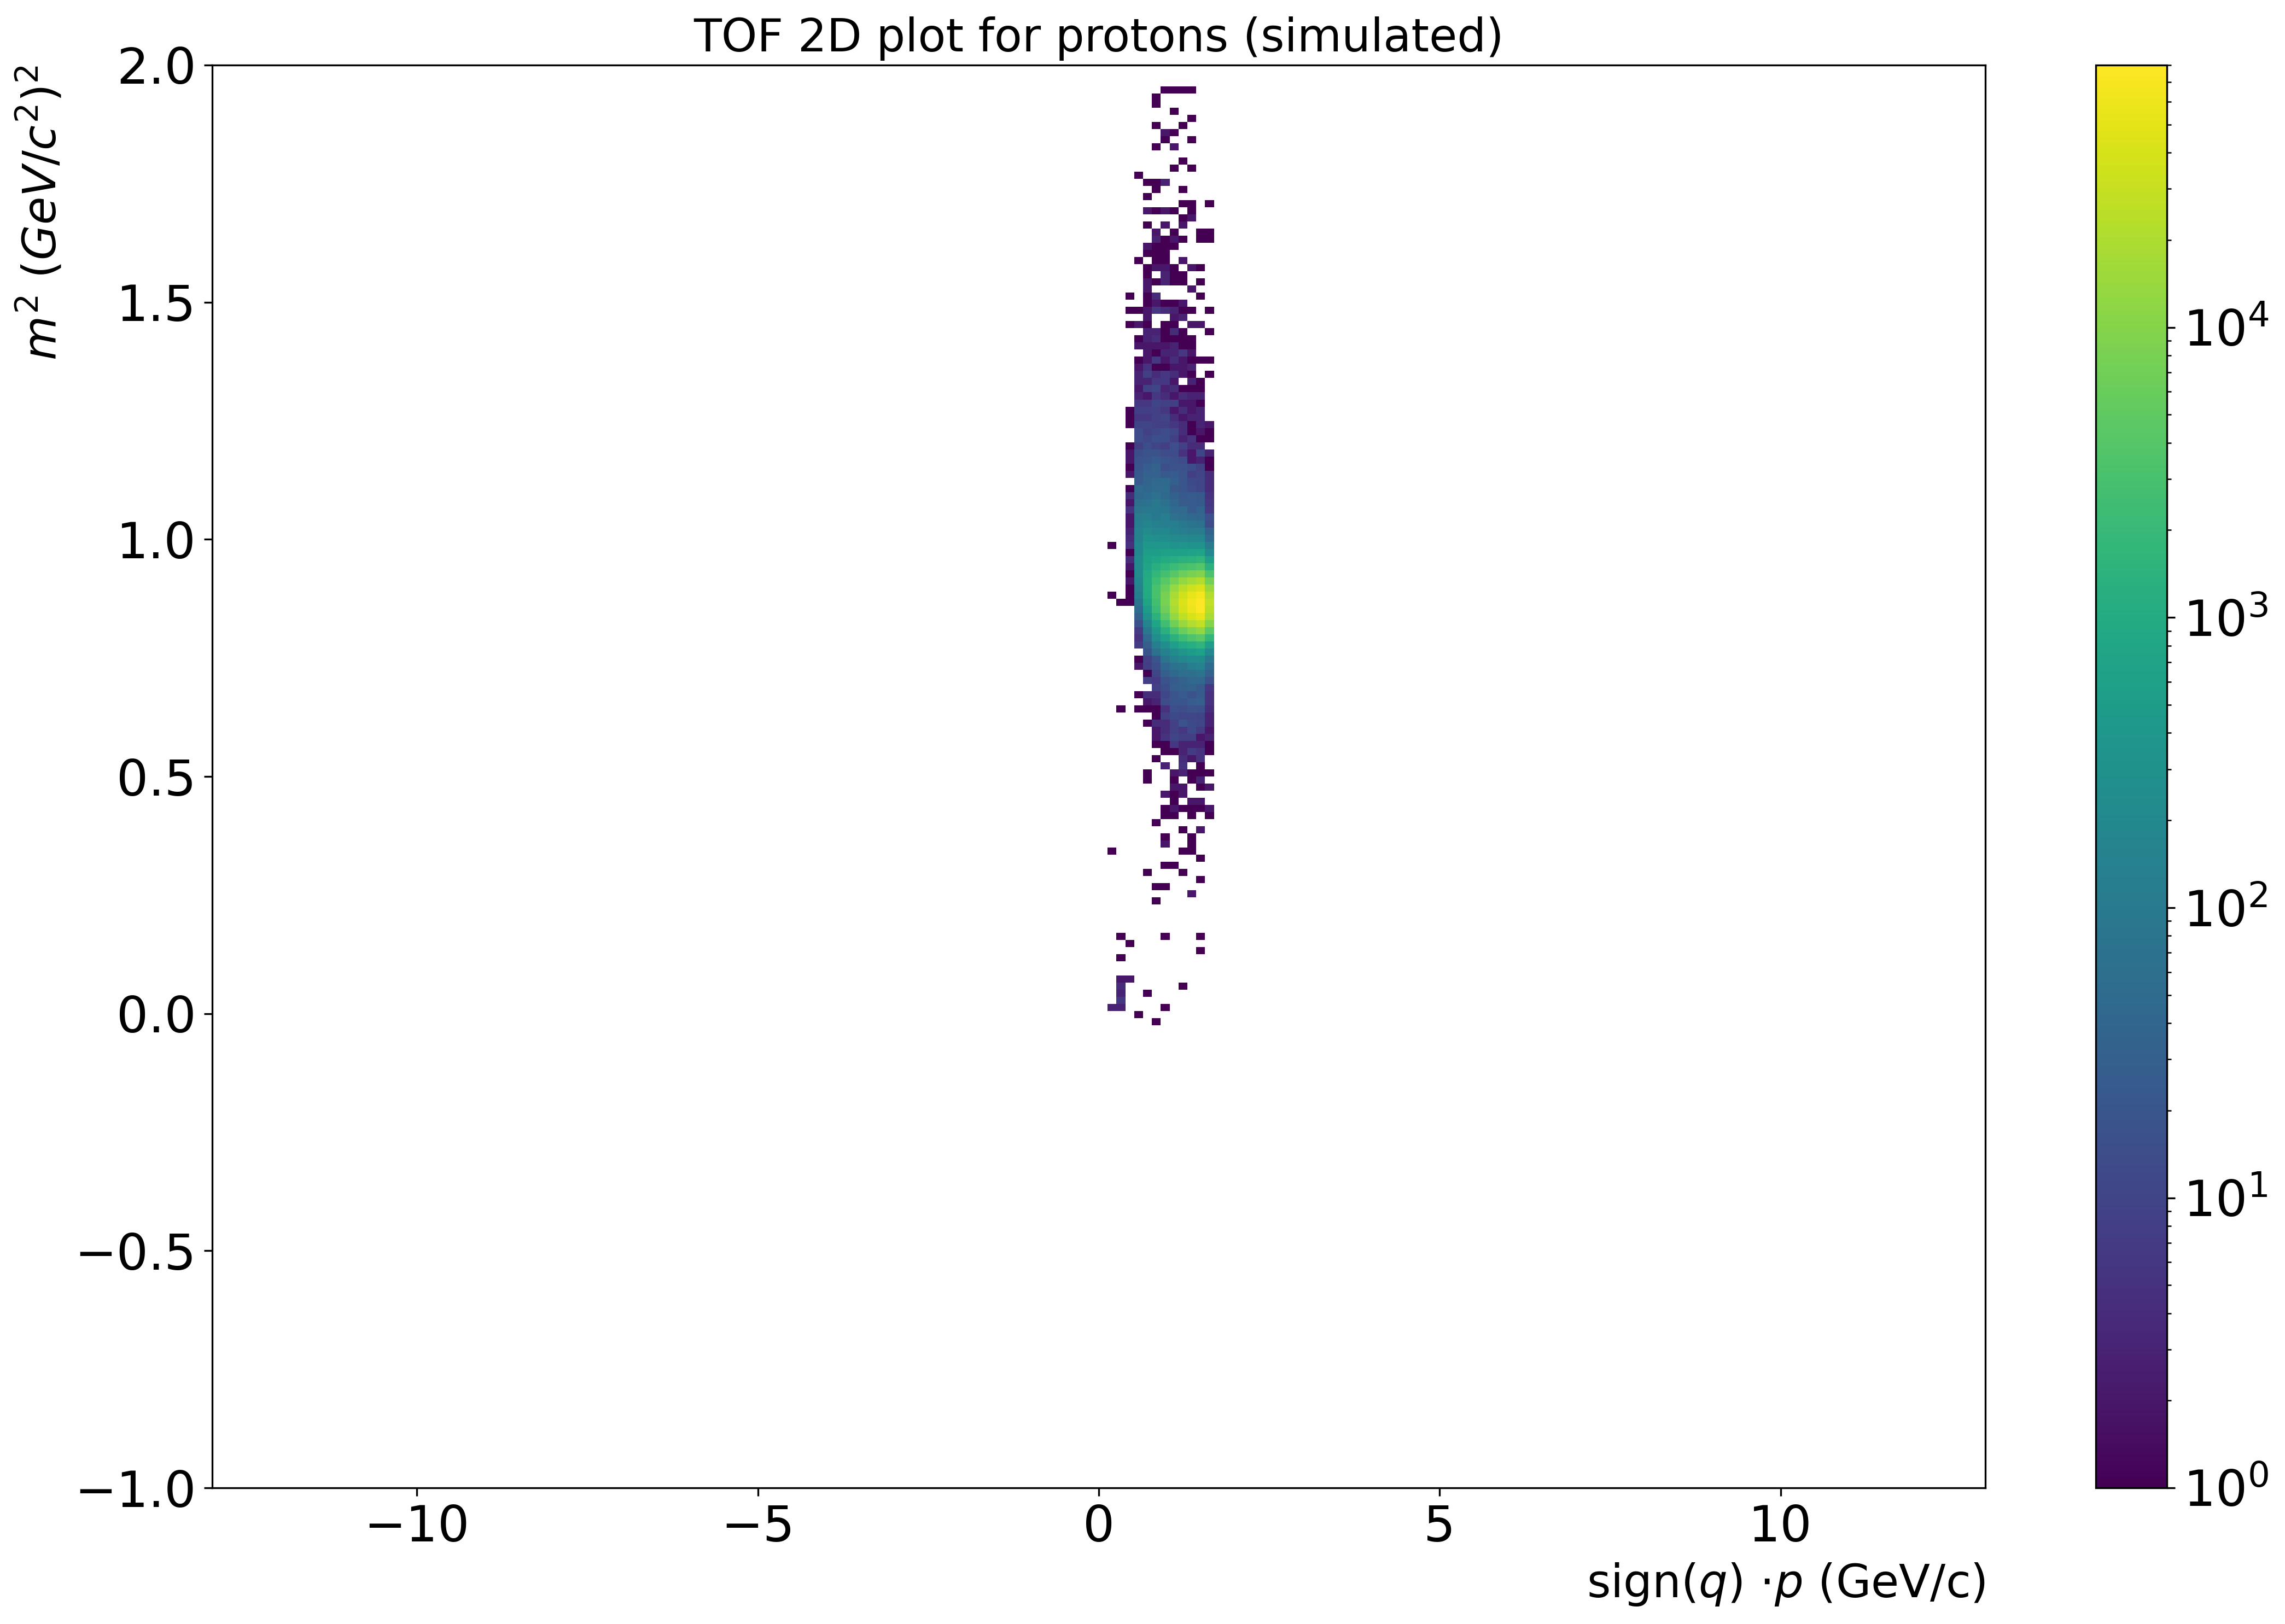

In [3]:
plotting_tools.tof_plot(
            df[df["Complex_pid"] == 0],
            json_file_name,
            f"protons (simulated)",
            save_fig=False,
        )

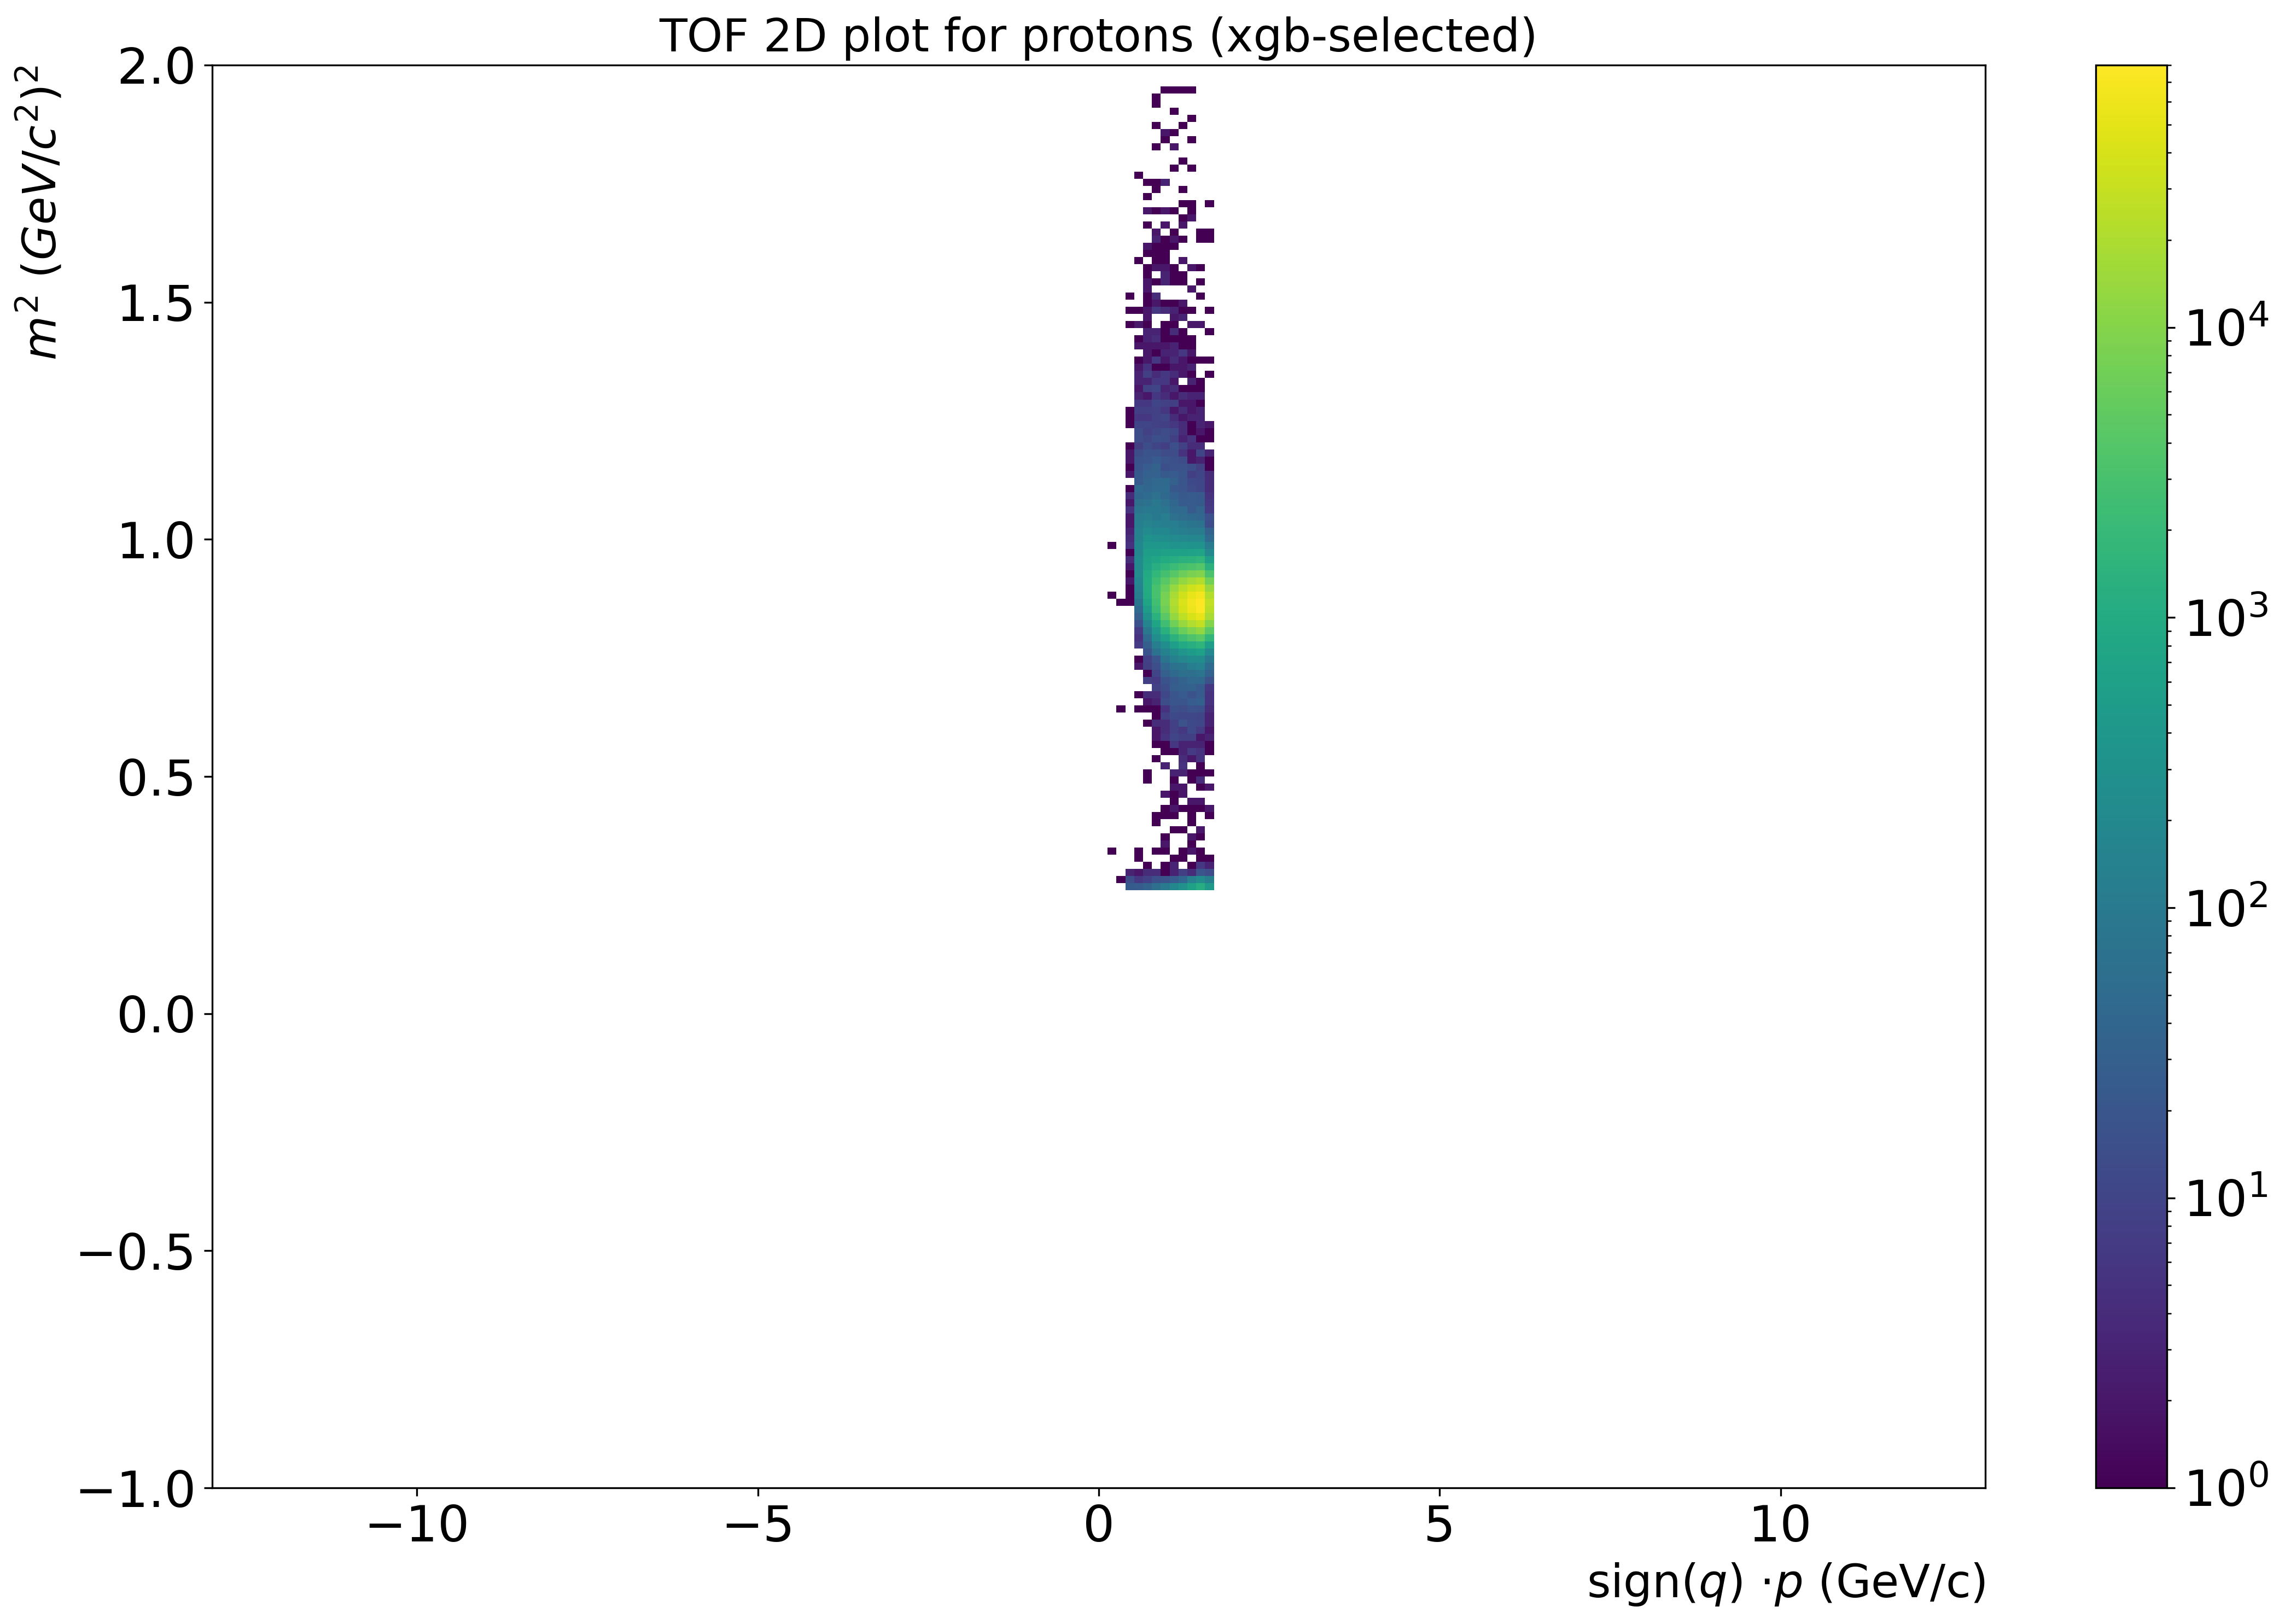

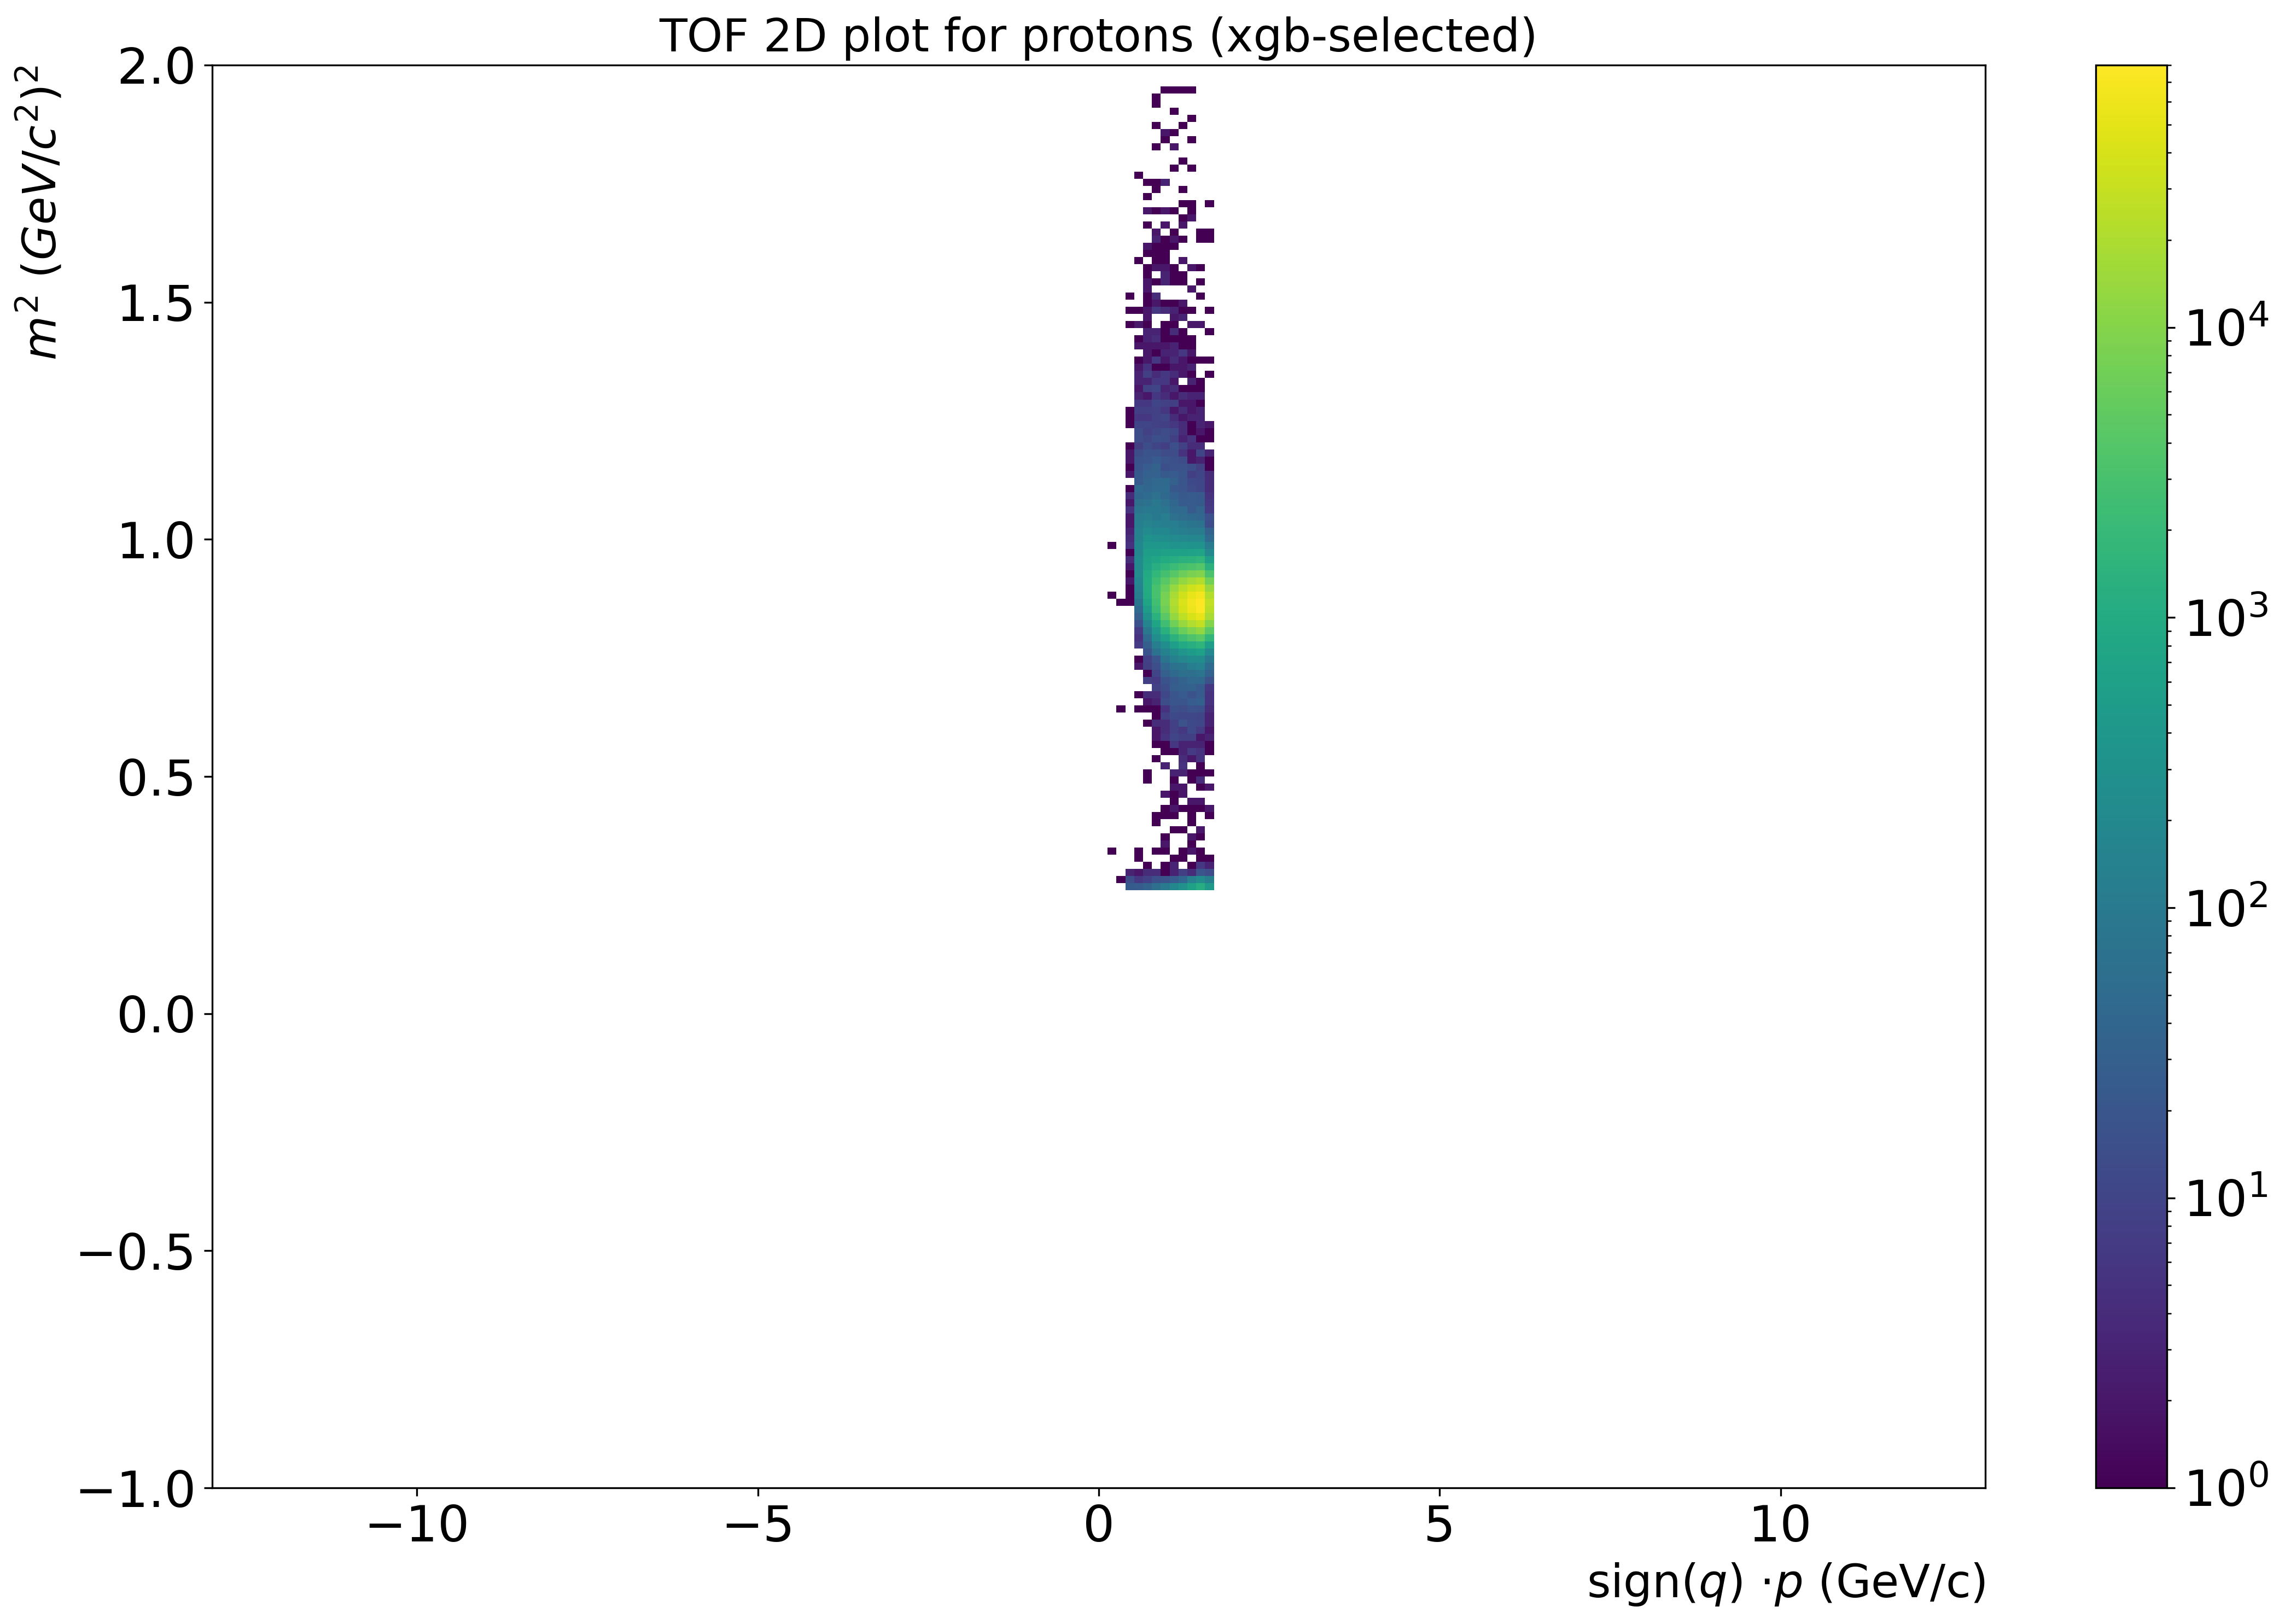

In [4]:
plotting_tools.tof_plot(
            df[df["xgb_preds"] == 0],
            json_file_name,
            f"protons (xgb-selected)",
            save_fig=False,
        )

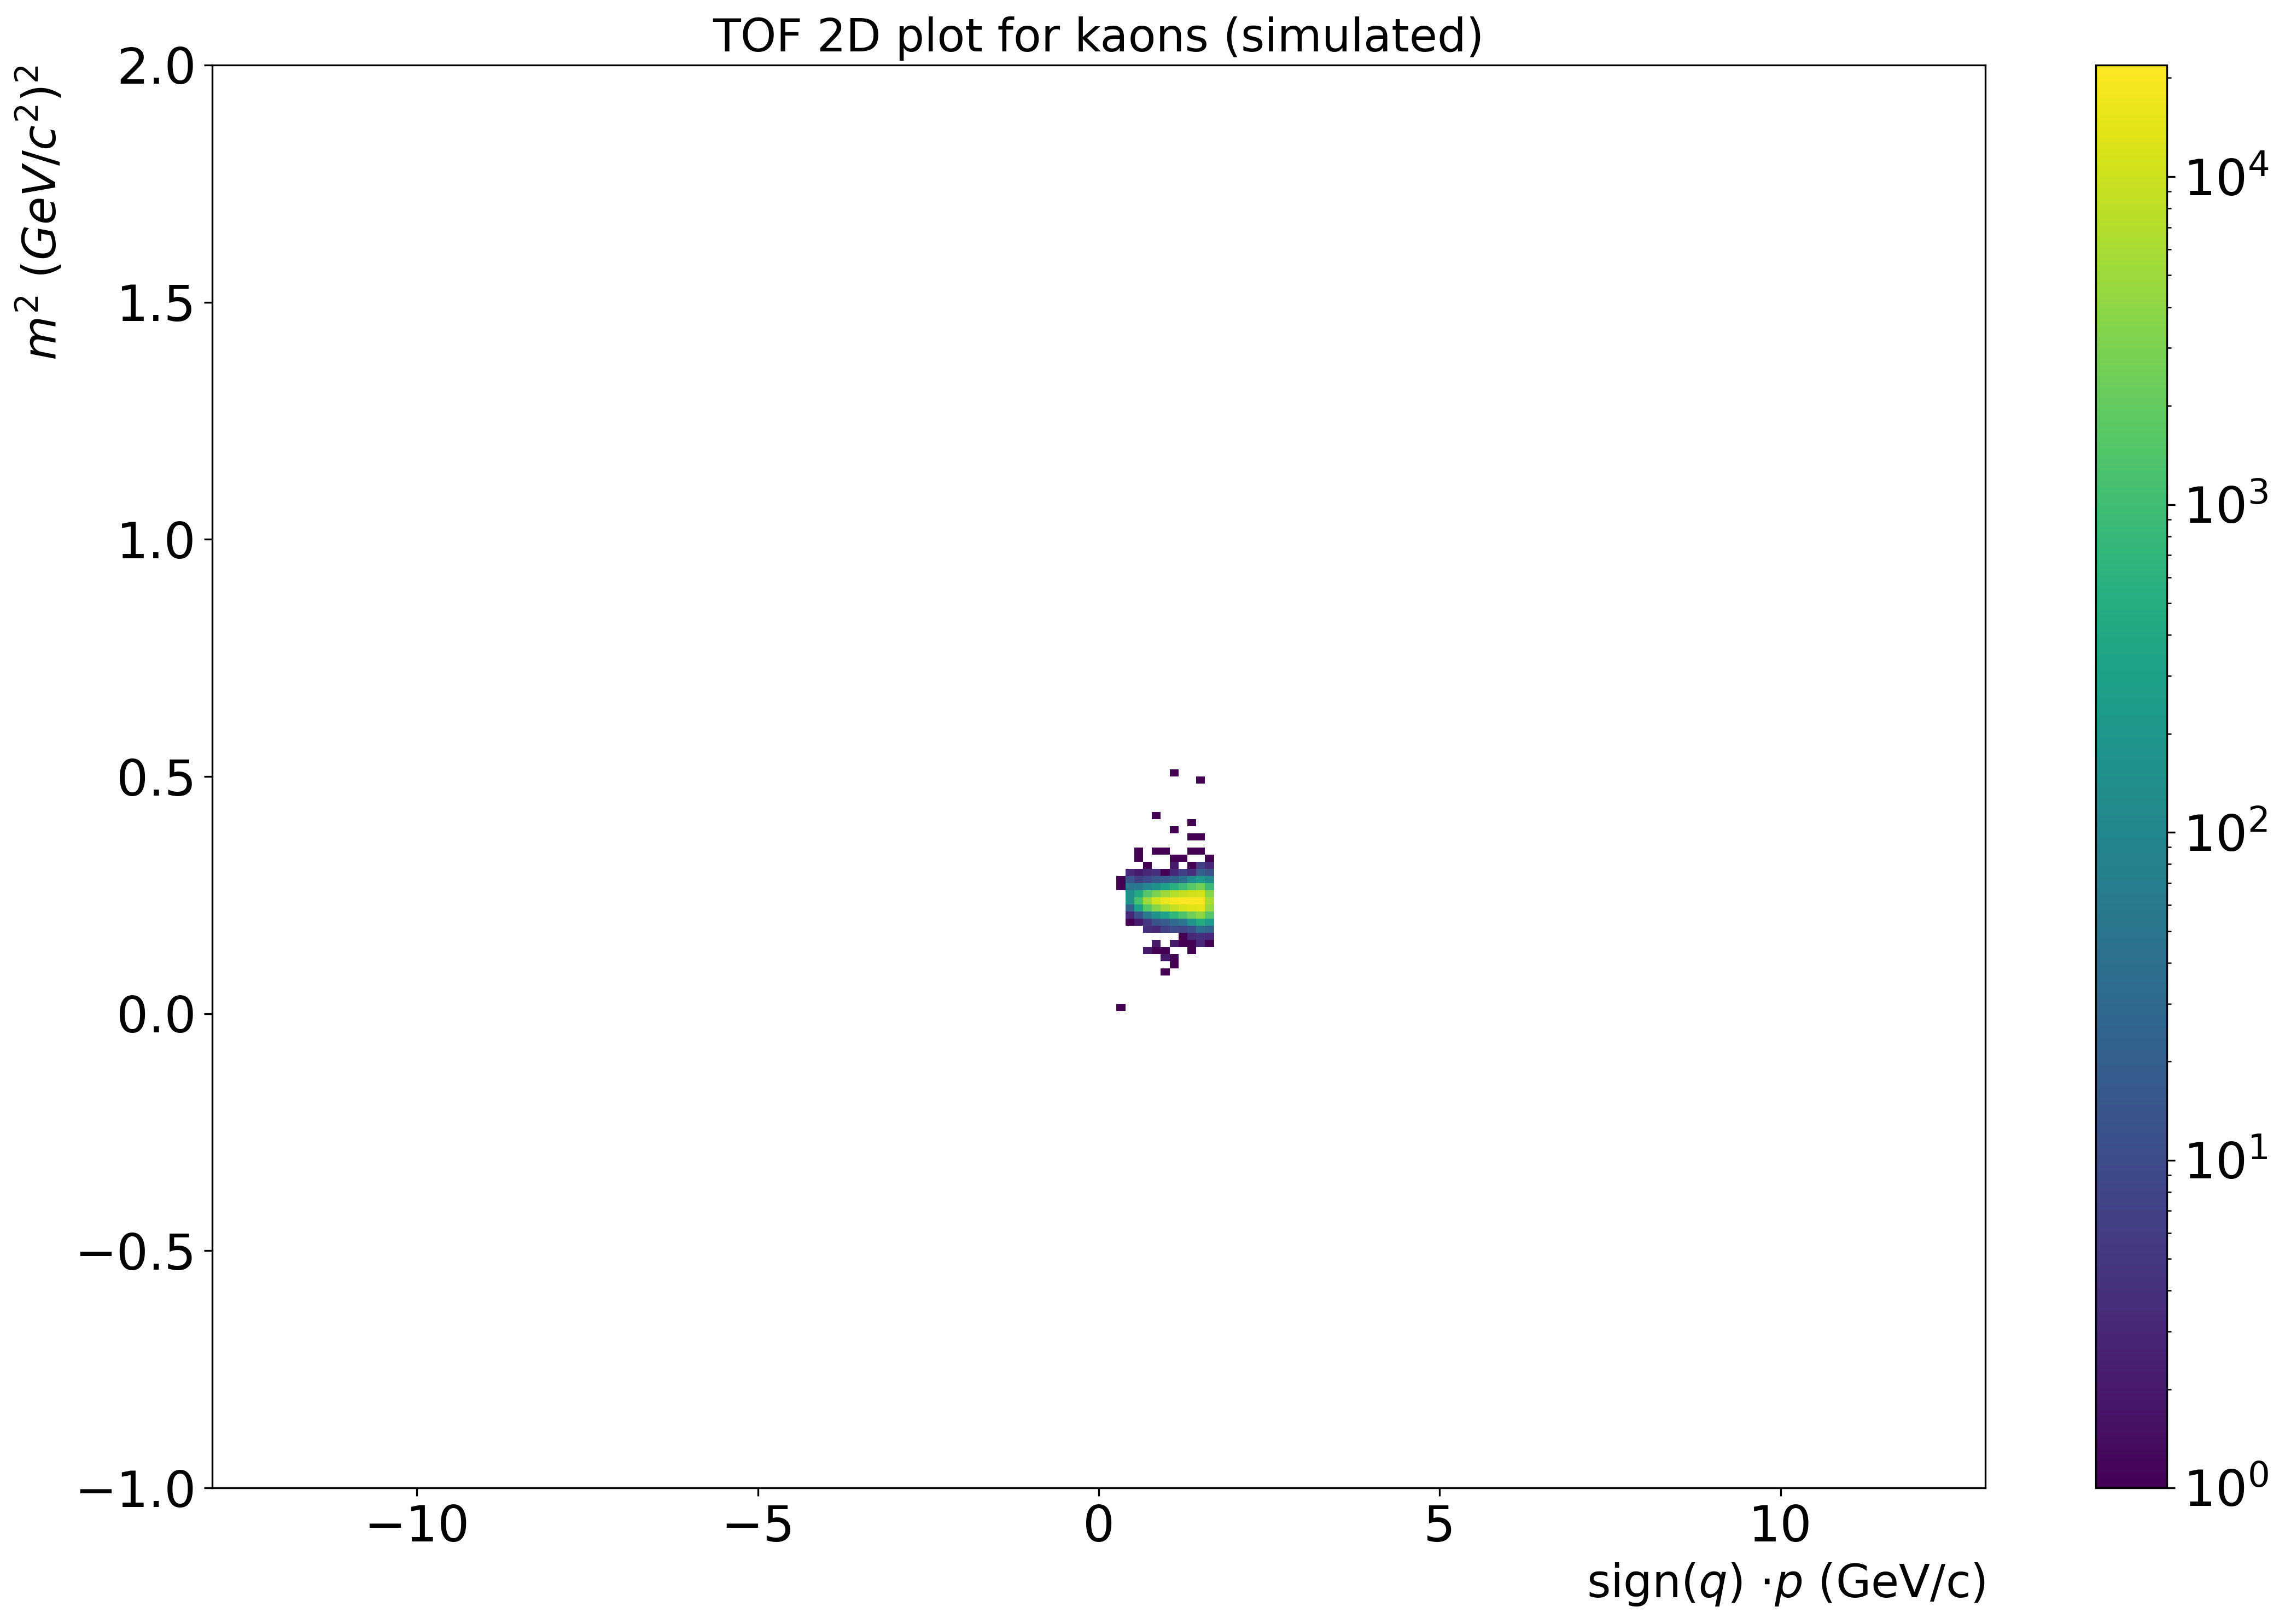

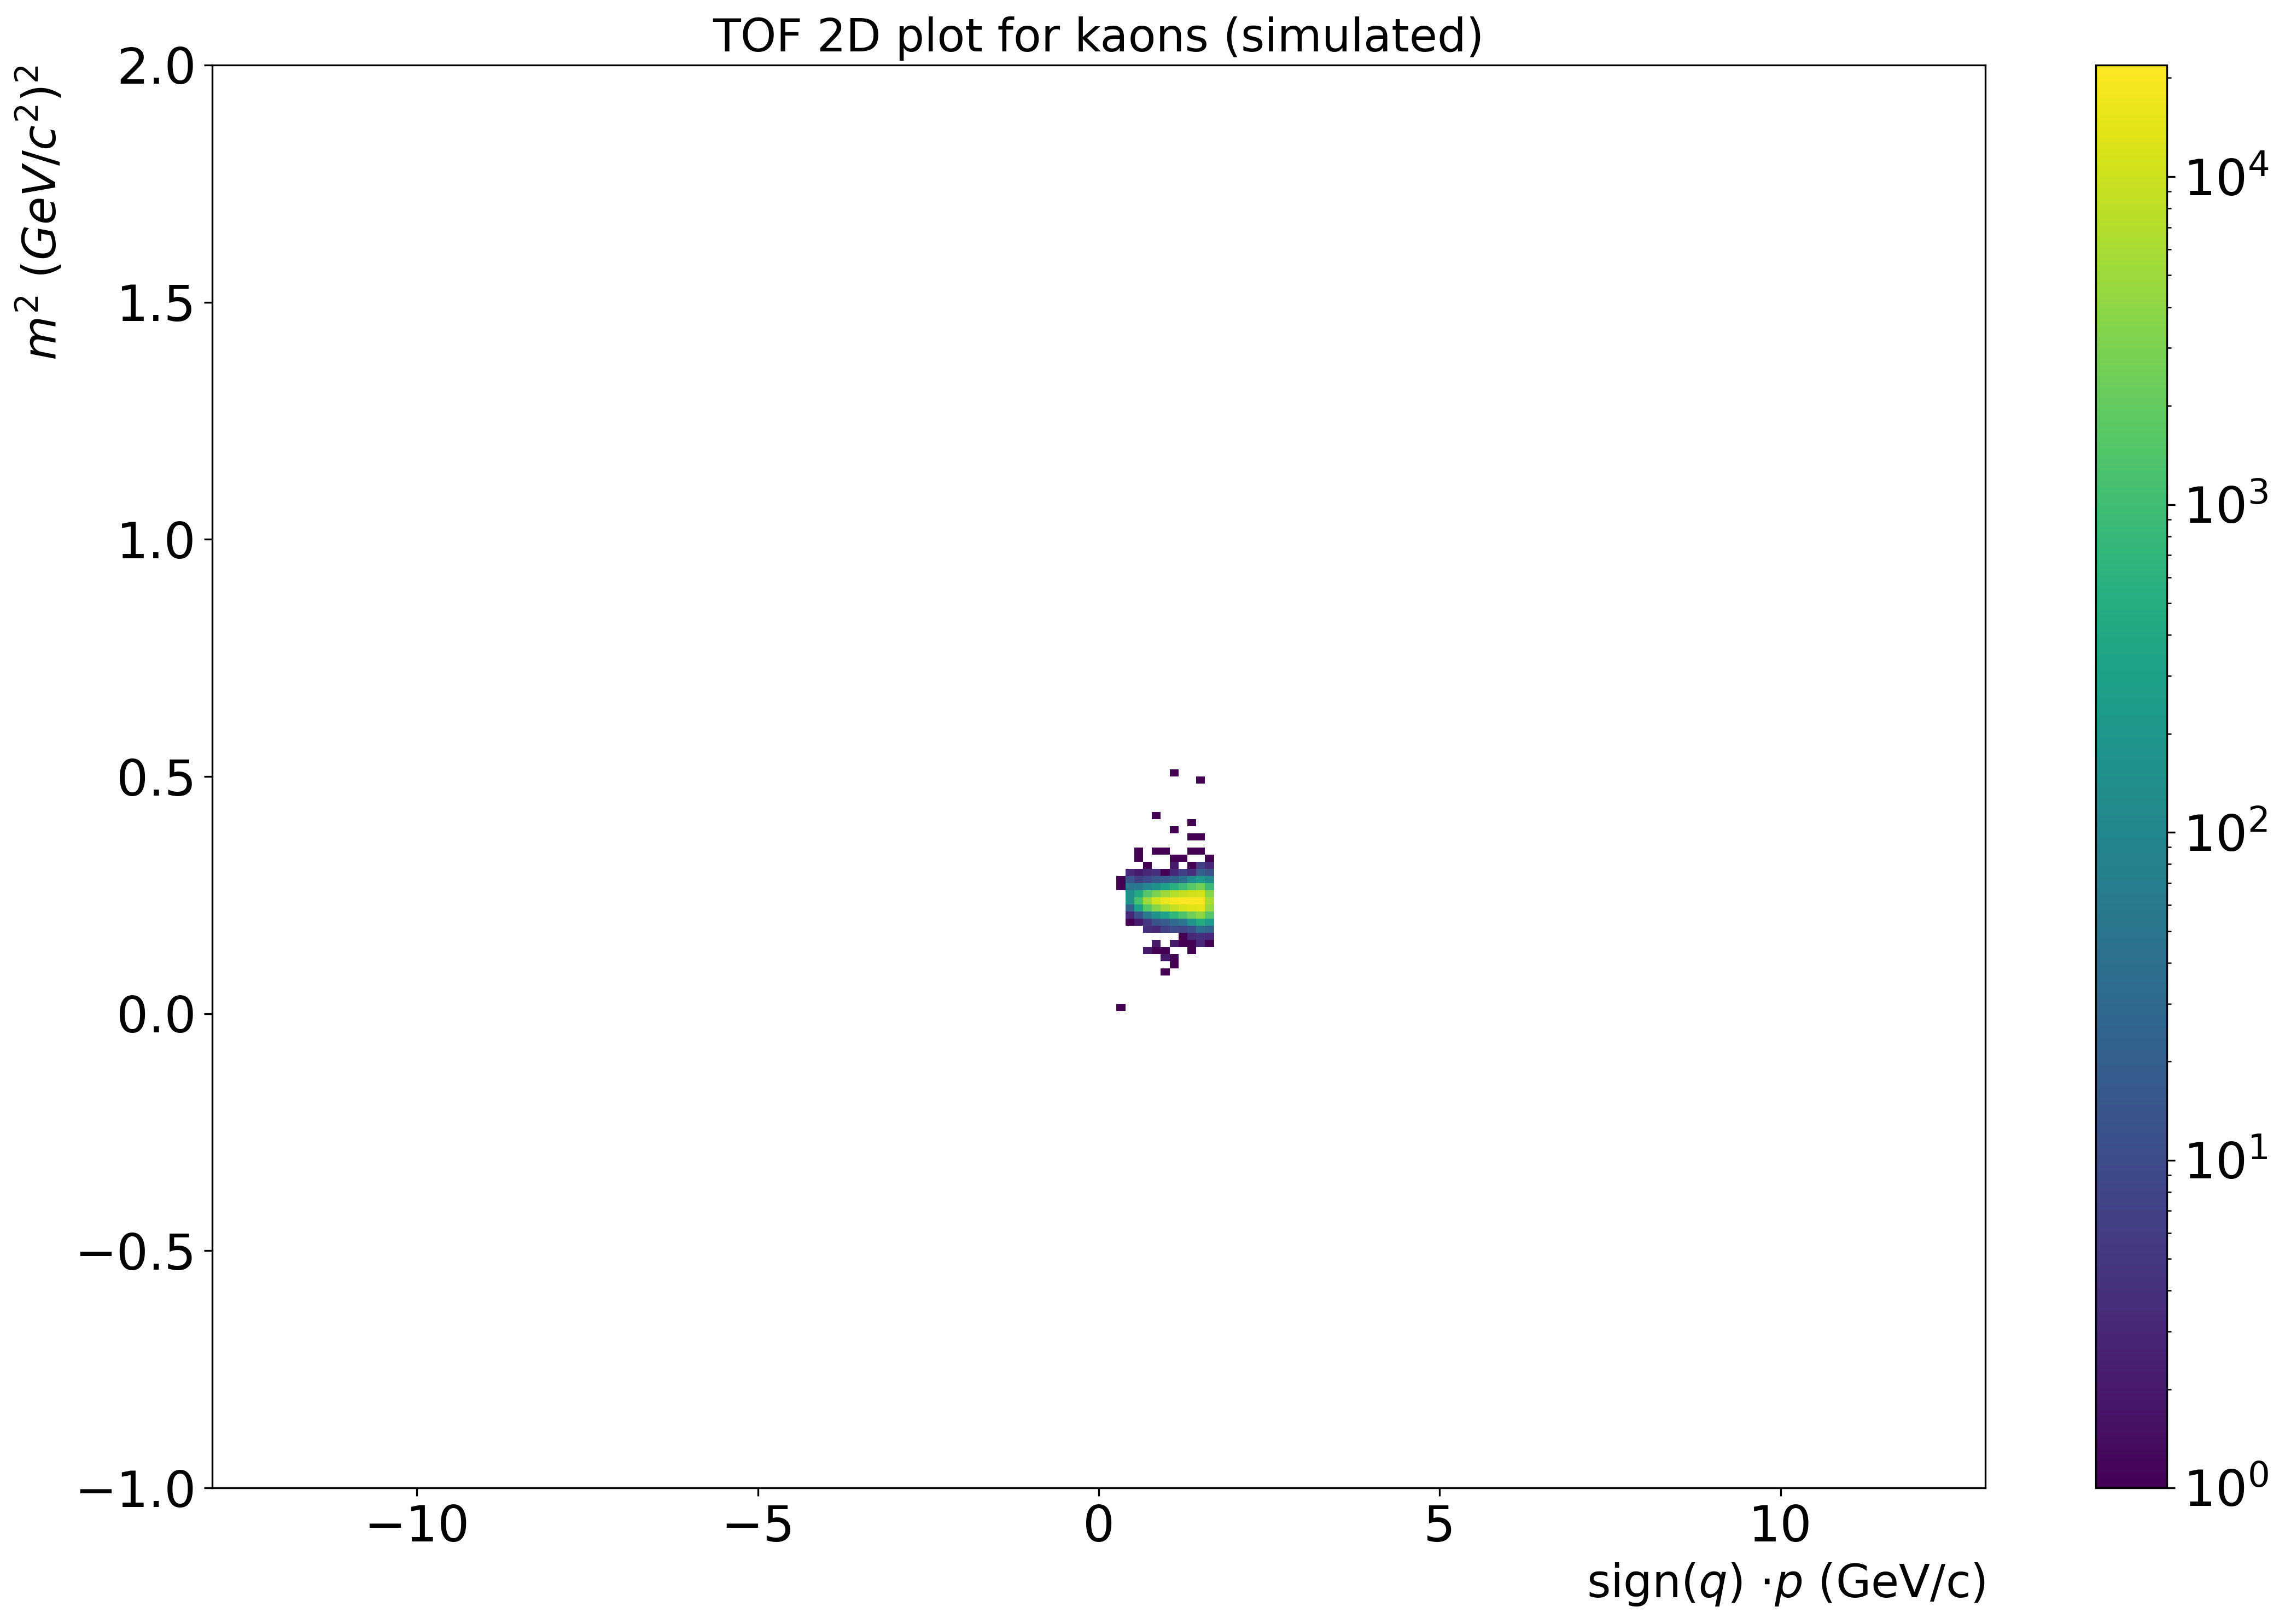

In [5]:
plotting_tools.tof_plot(
            df[df["Complex_pid"] == 1],
            json_file_name,
            f"kaons (simulated)",
            save_fig=False,
        )

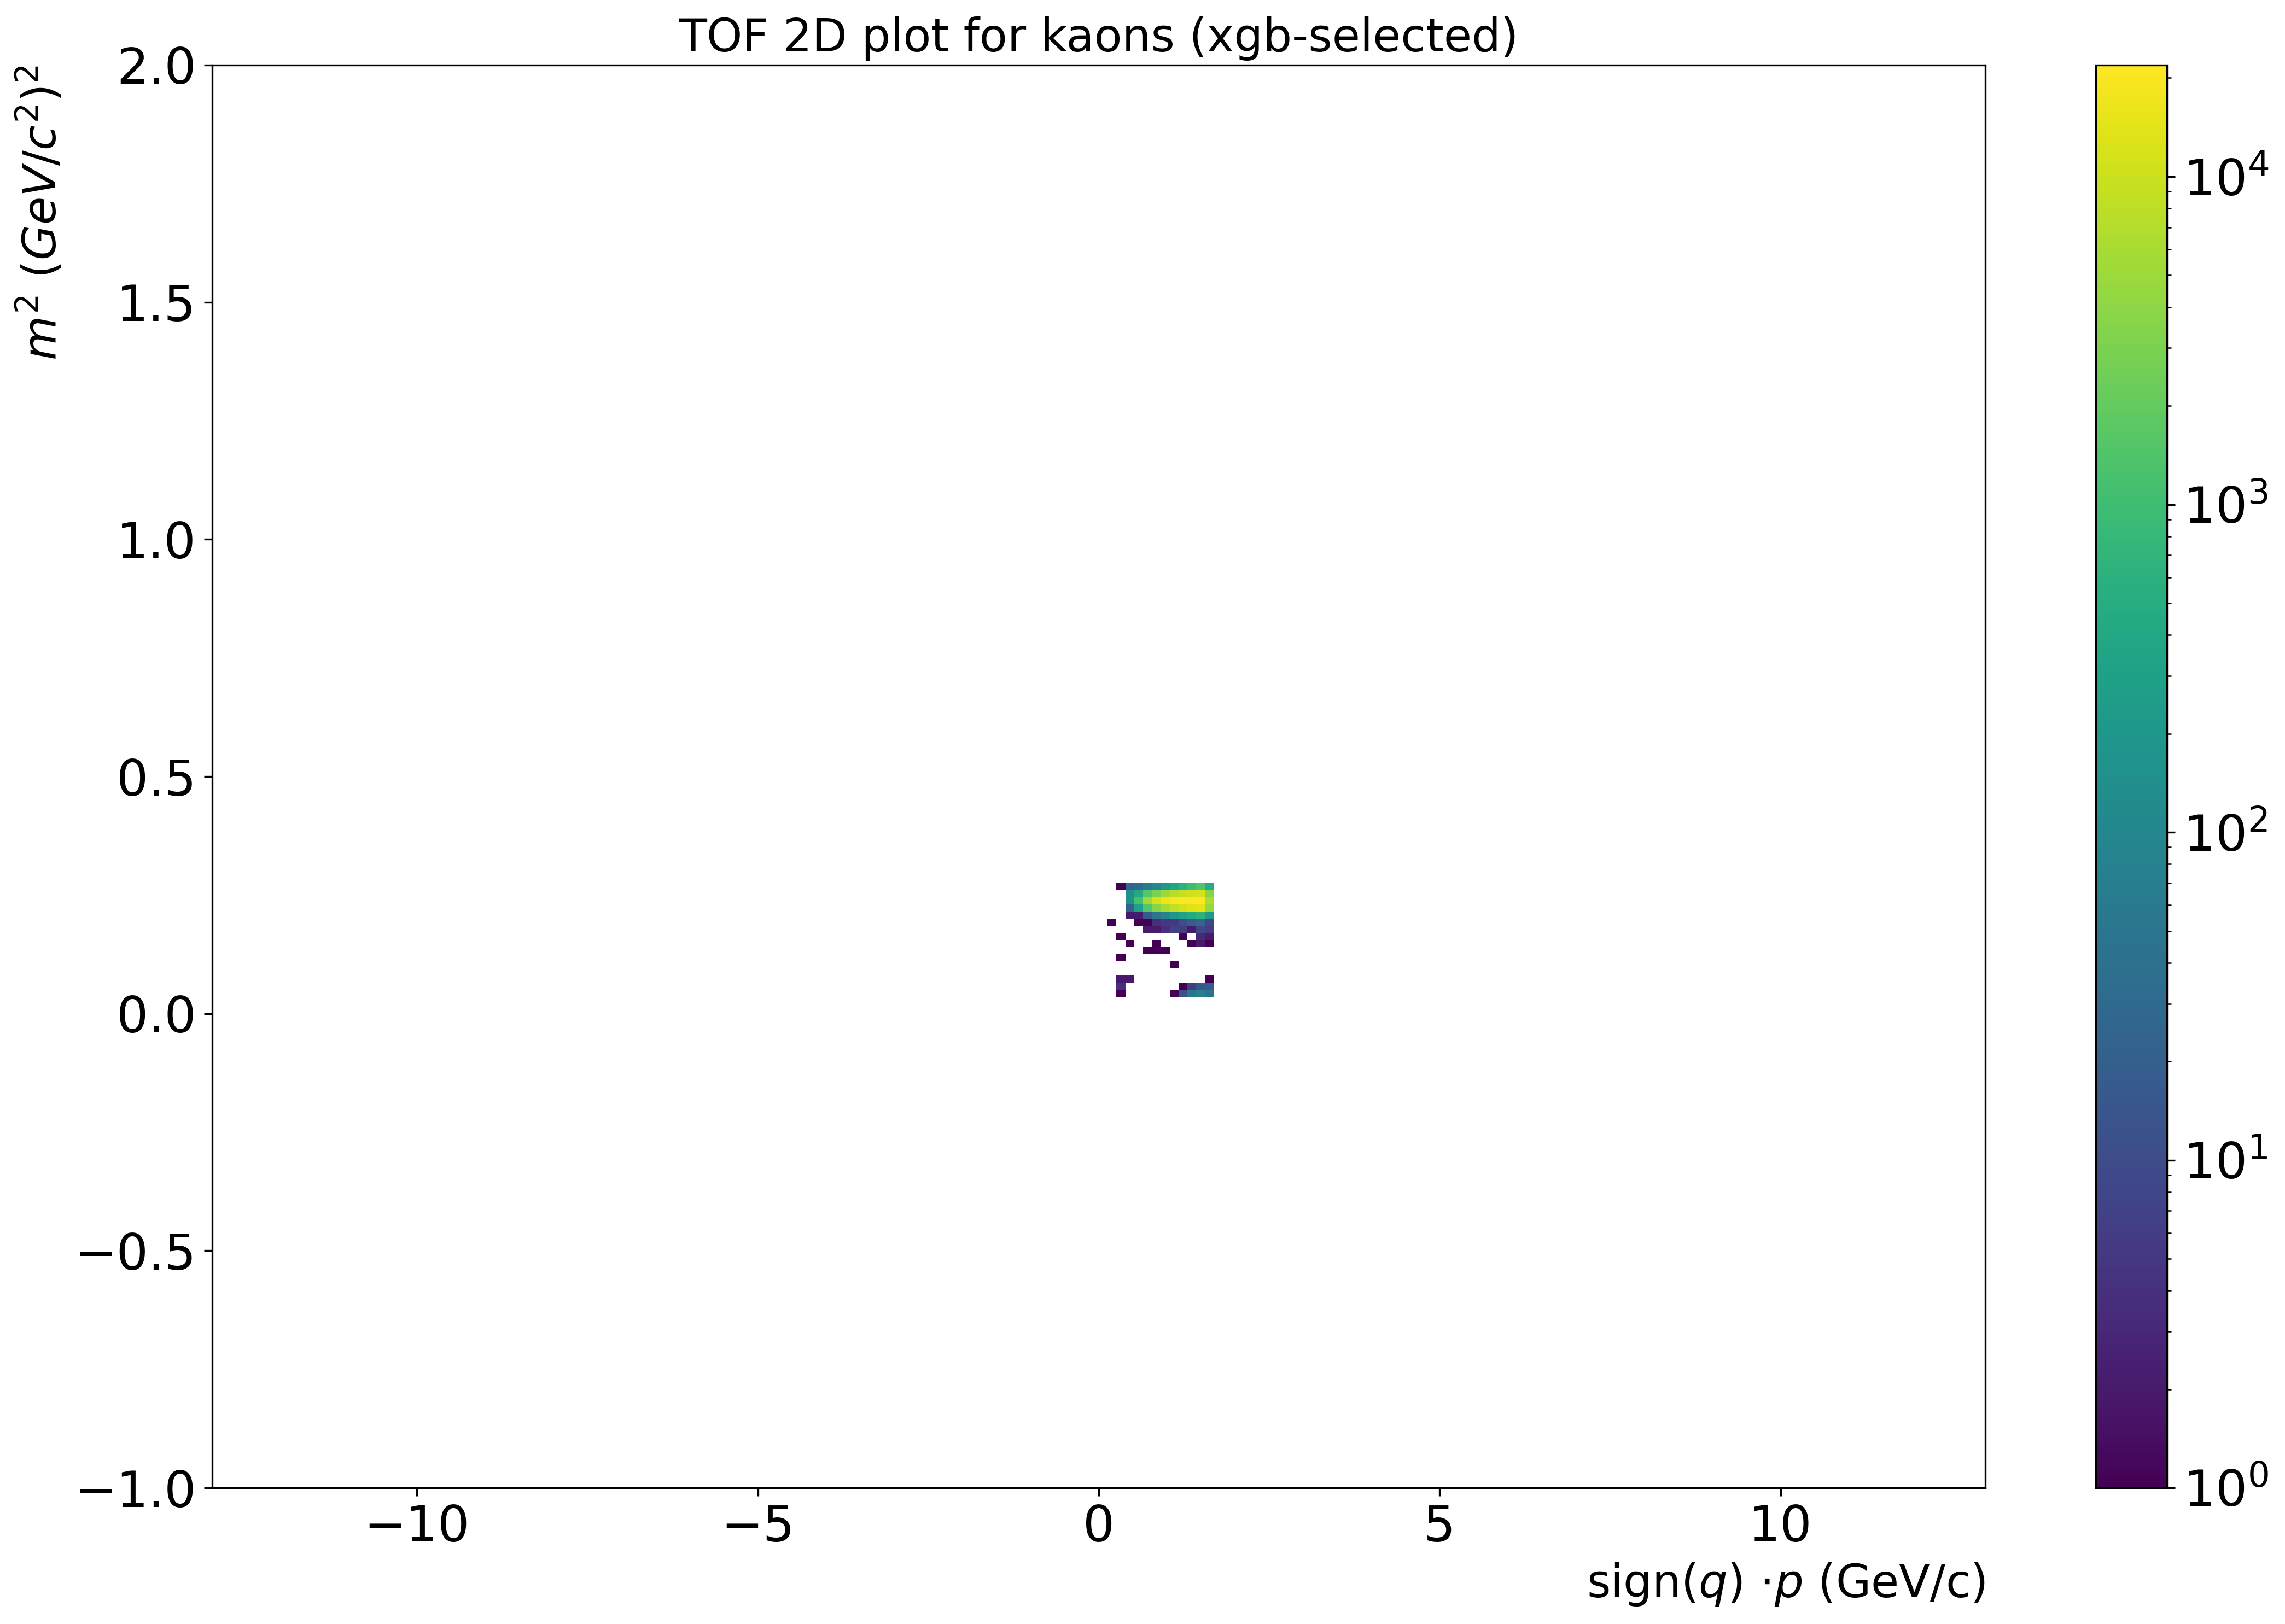

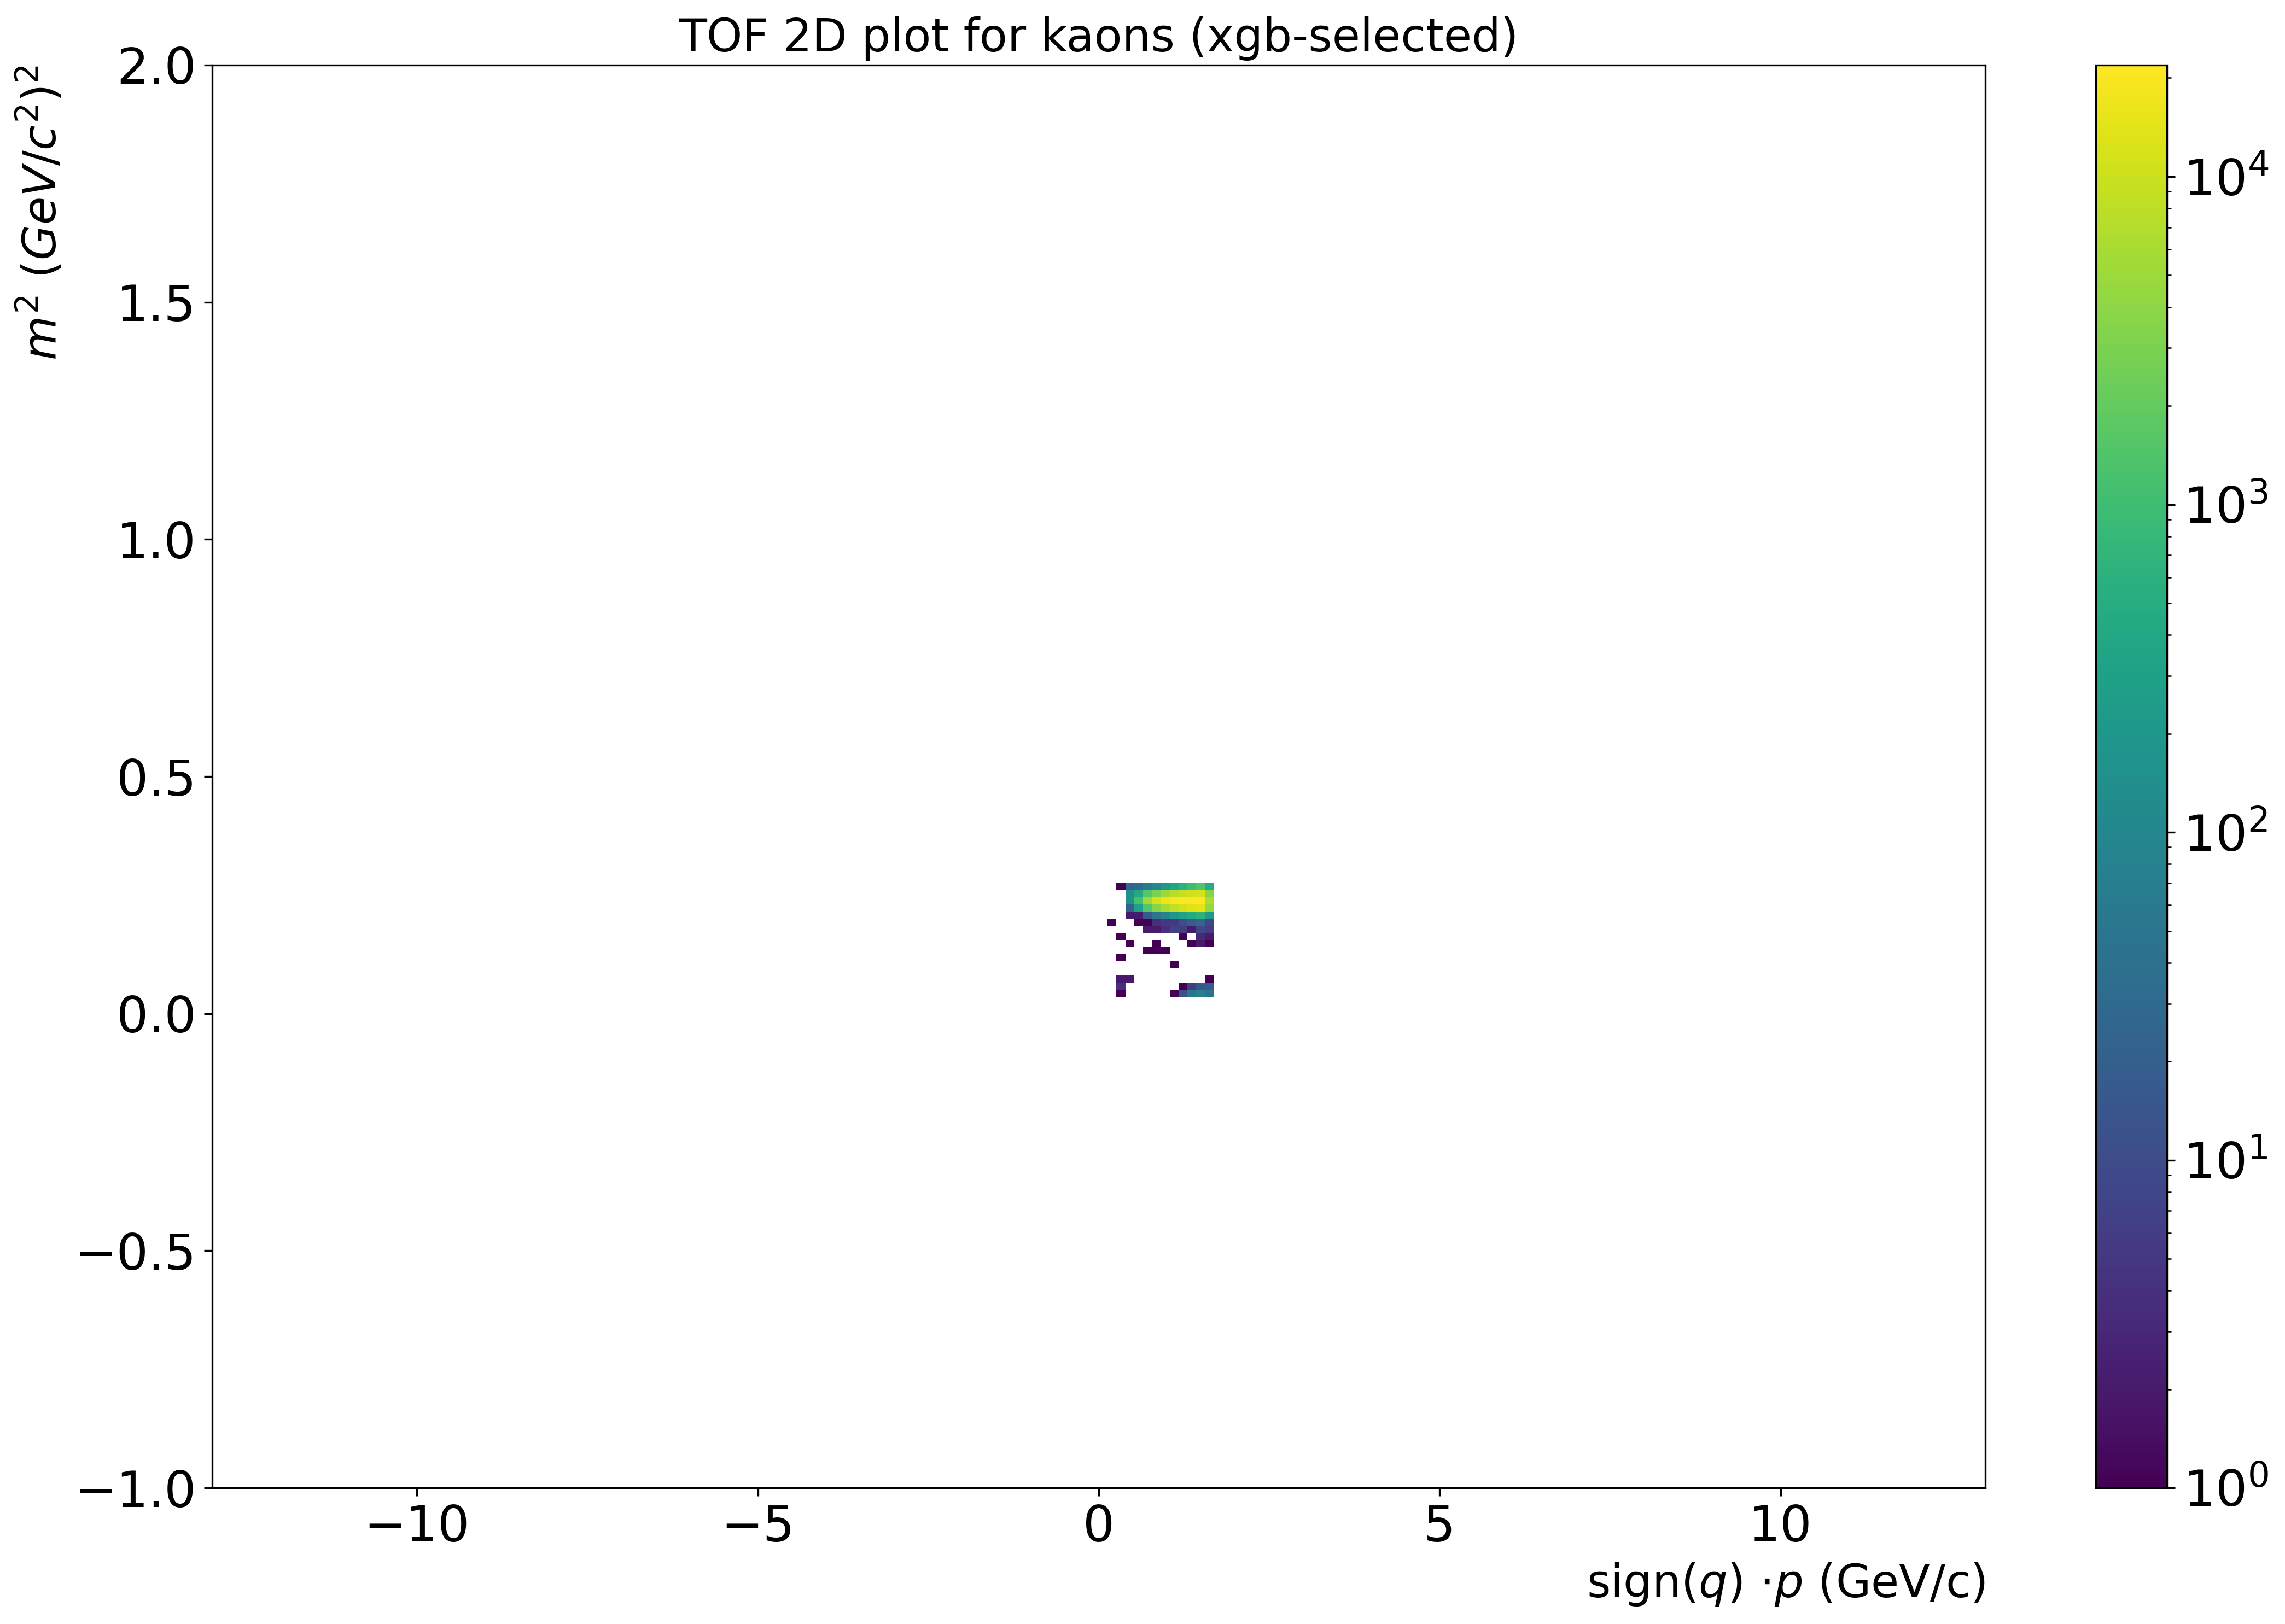

In [6]:
plotting_tools.tof_plot(
            df[df["xgb_preds"] == 1],
            json_file_name,
            f"kaons (xgb-selected)",
            save_fig=False,
        )

Let's take a closer look at xgb-selected protons with $$mass^2 < 0.4$$ which are MC-true kaons

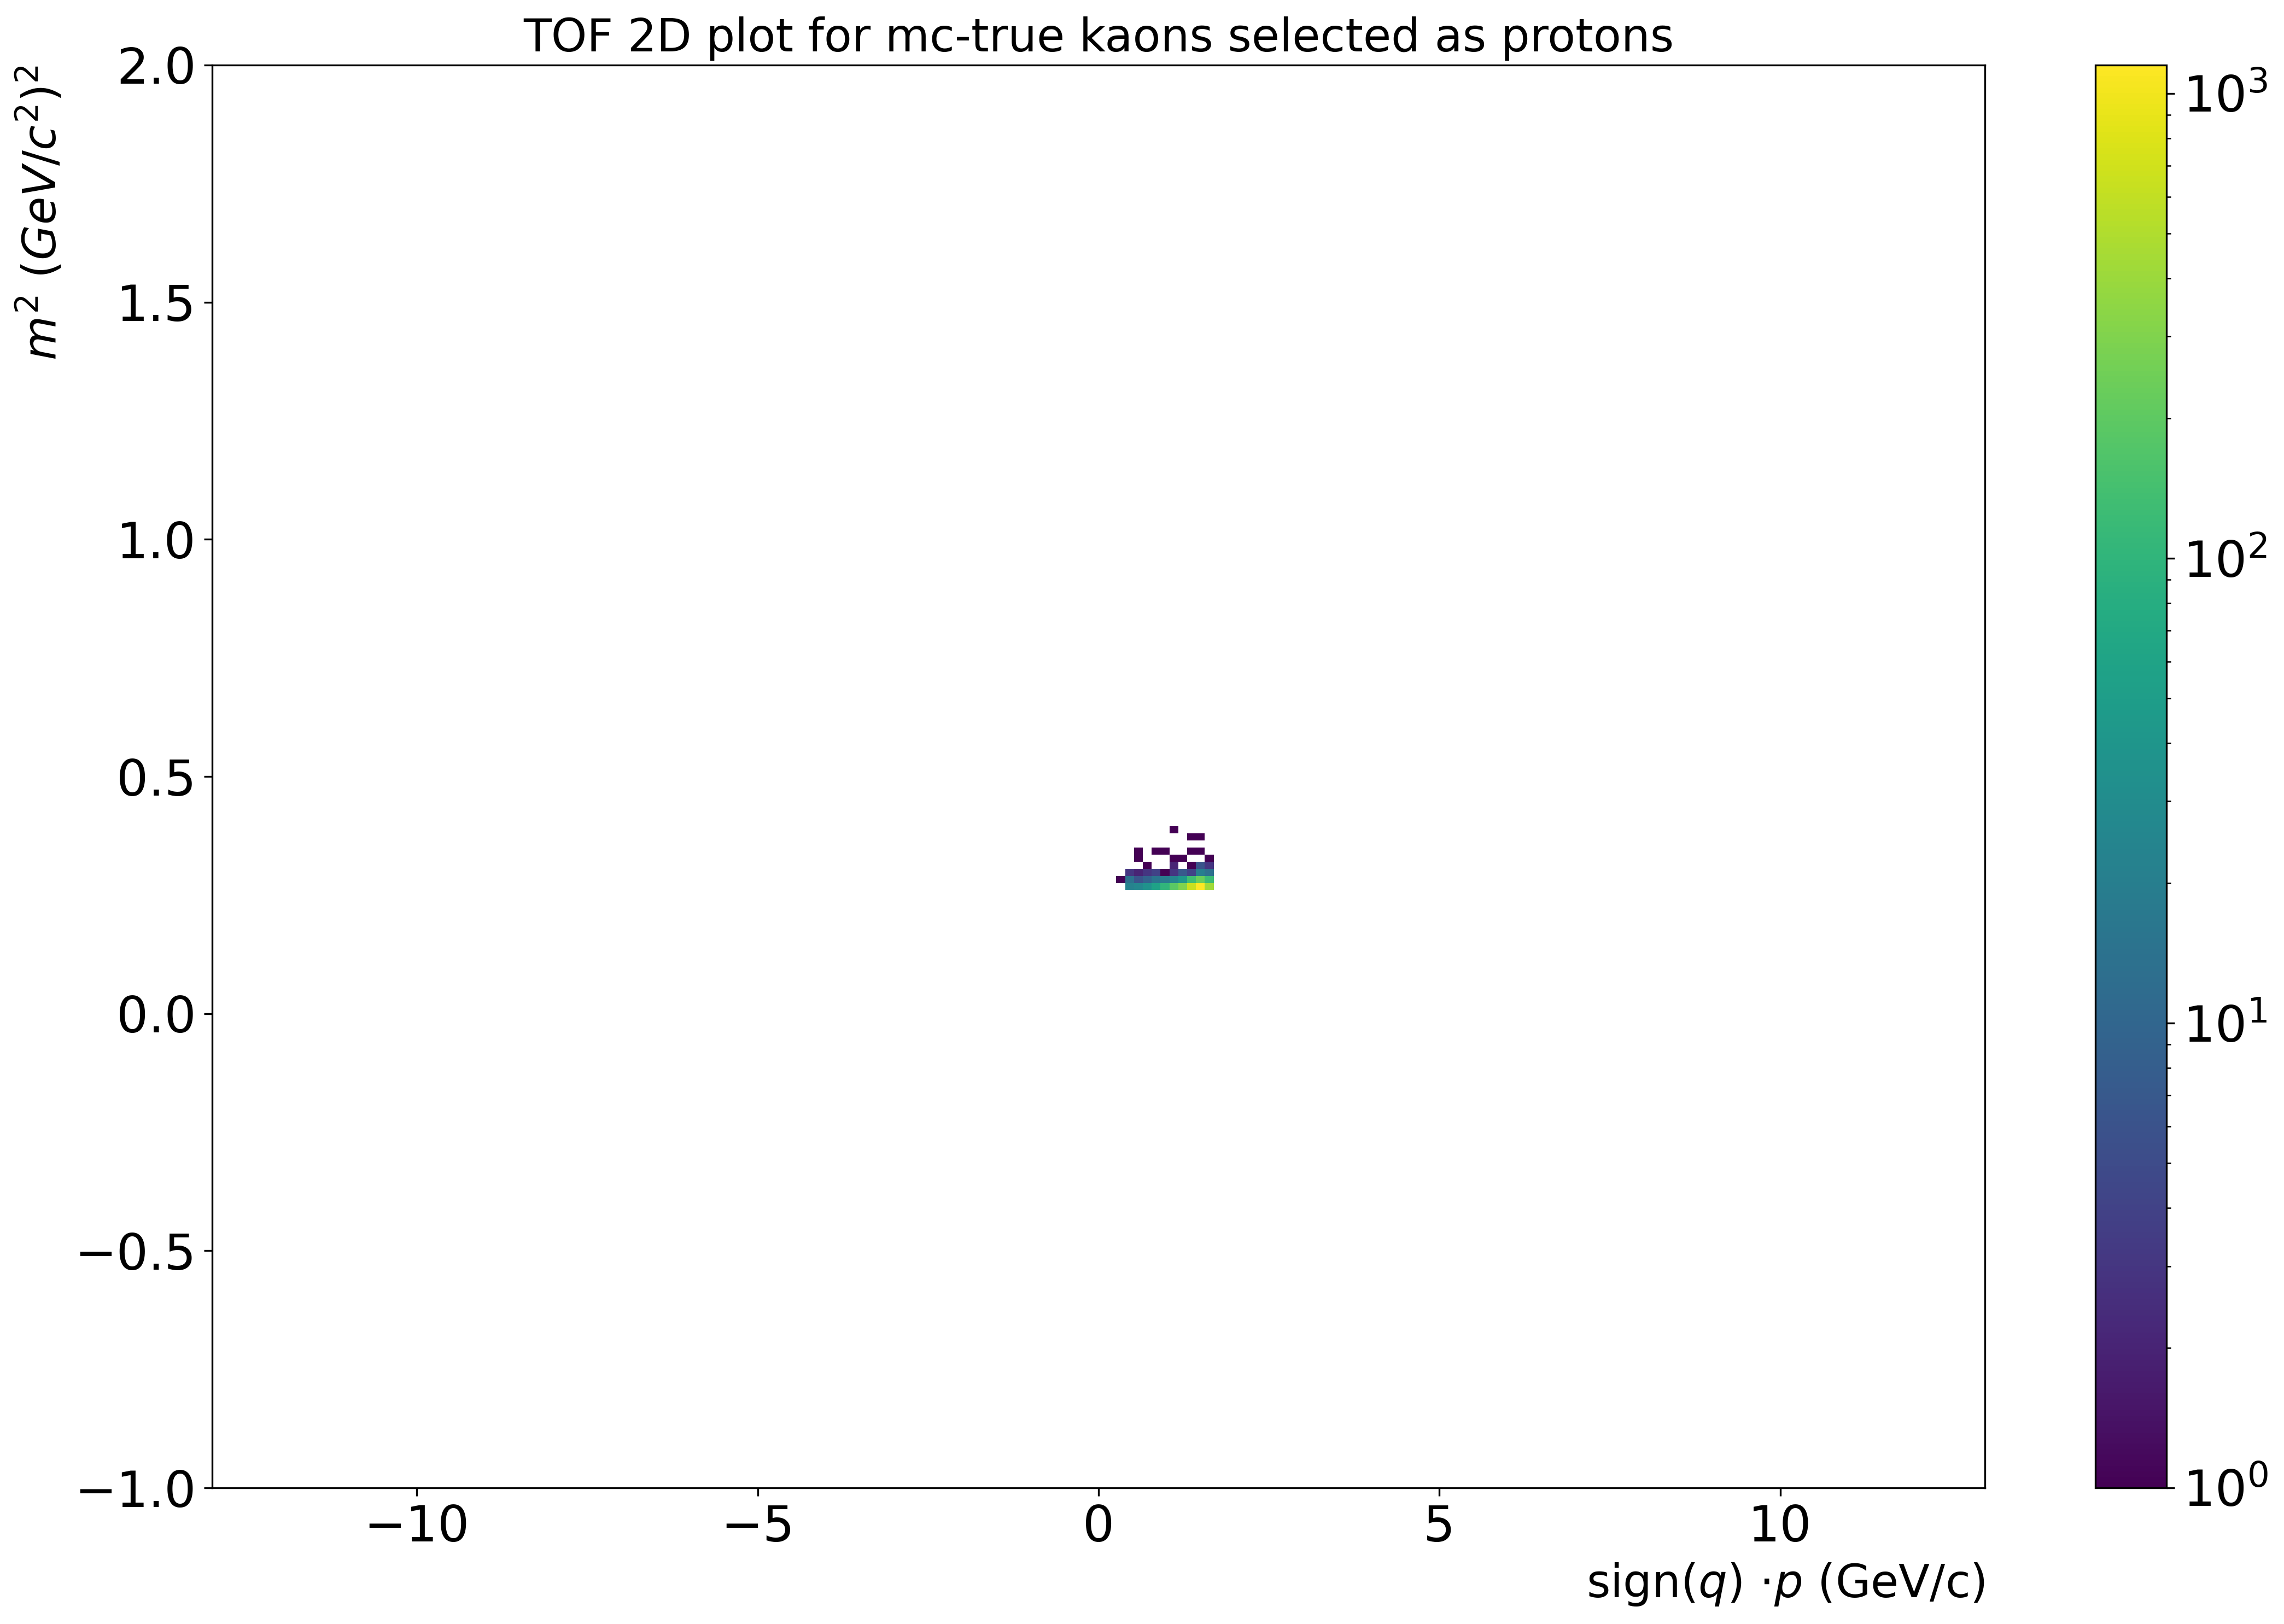

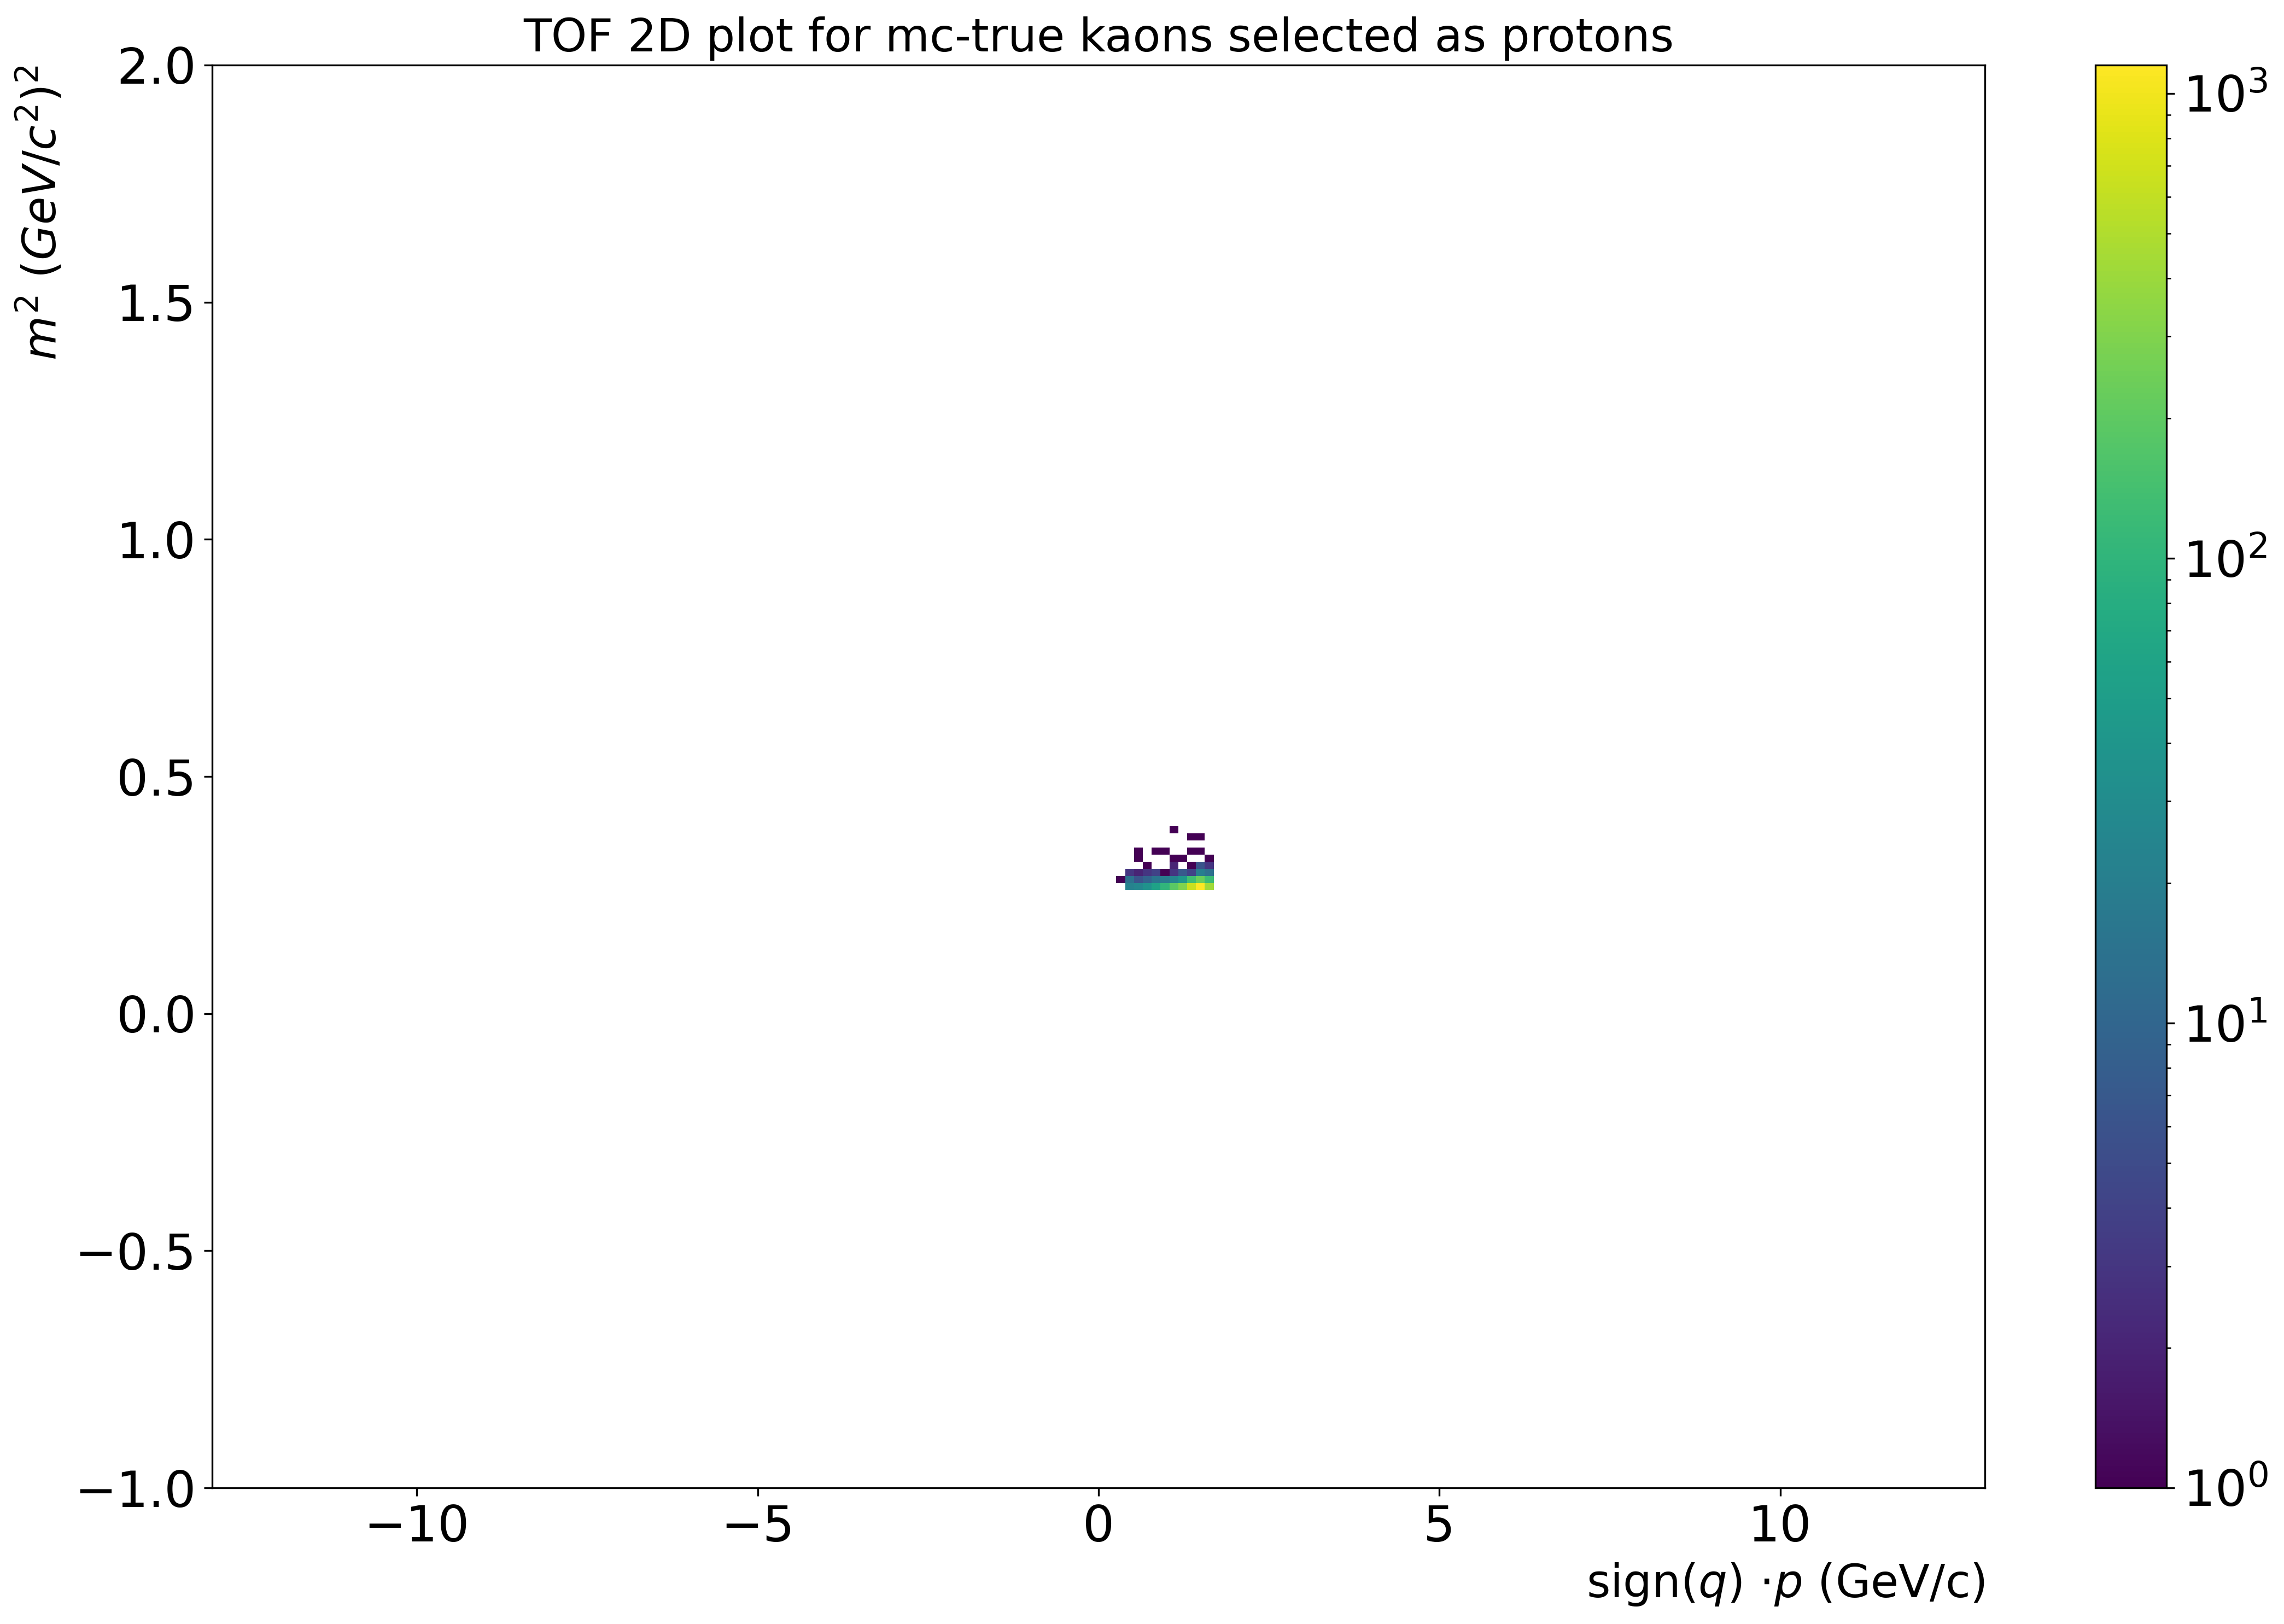

In [21]:
investigate_df = df[(df["xgb_preds"] == 0) & (df["Complex_mass2"] < .4) & (df["Complex_pid"] == 1)]
plotting_tools.tof_plot(
            investigate_df,
            json_file_name,
            f"mc-true kaons selected as protons",
            save_fig=False,
        )

In [8]:
#lets prepare shap explainer
features_for_train = json_tools.load_features_for_train(json_file_name)
model_hdl = ModelHandler()
model_hdl.load_model_handler(model_name)
feature_names = [item.replace("Complex_", "") for item in features_for_train]
explainer = shap.TreeExplainer(
        model_hdl.get_original_model(), n_jobs=8, approximate=False
    )
shap_values = explainer.shap_values(investigate_df[features_for_train])

Let's take a look at the first, random particle in this group

In [9]:
investigated_row = investigate_df.head(1)
investigated_row

,Complex_E,Complex_T,Complex_chi2_ov_ndf_vtx,Complex_eta,Complex_l,Complex_mass,Complex_mass2,Complex_p,Complex_pT,Complex_phi,...,Complex_vtx_chi2,Complex_M,Complex_id,Complex_mother_id,Complex_pid,Complex_q,model_output_0,model_output_1,model_output_2,xgb_preds
11318,1.472112,0.978435,0.813122,1.907837,762.136353,0.493677,0.266806,1.386866,0.402755,2.91642,...,0.643112,156.0,34.0,-1.0,1.0,1.0,0.825077,0.174902,0.000021,0


And especially its values which are used for training

In [10]:
investigated_row[features_for_train]

,Complex_mass2,Complex_vtx_chi2,Complex_chi2_ov_ndf_vtx
11318,0.266806,0.643112,0.813122


In [11]:
data = investigated_row[features_for_train].iloc[0]

lets check probability of this particle being a kaon

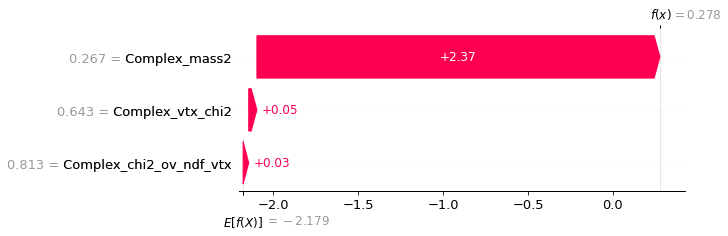

In [12]:
shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=data,
            feature_names=features_for_train,
        )
    )
)

And now being a proton

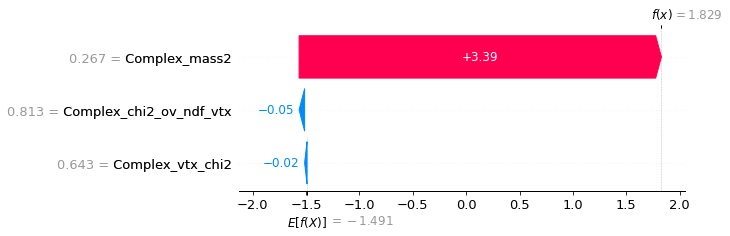

In [13]:

shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[0][0],
            base_values=explainer.expected_value[0],
            data=data,
            feature_names=features_for_train,
        )
    )
)

And maybe a pion?

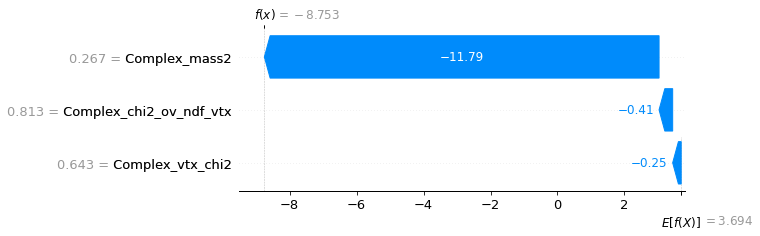

In [14]:

shap.waterfall_plot(
    (
        shap.Explanation(
            values=shap_values[2][0],
            base_values=explainer.expected_value[2],
            data=data,
            feature_names=features_for_train,
        )
    )
)

In summary, the base probability of a particle being a proton is higher than for a kaon, but also in this mass^2 region the probability is still higher for it to be a proton than a kaon

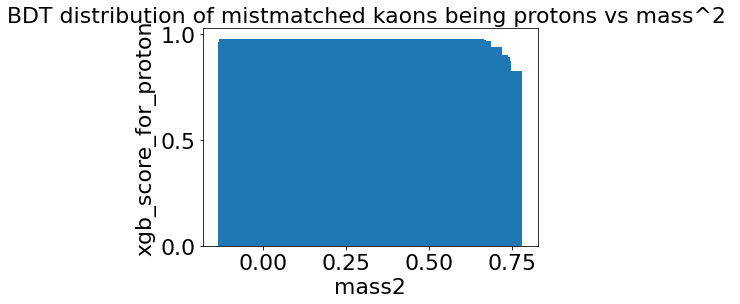

In [15]:
plt.bar(investigate_df["Complex_mass2"], investigate_df["model_output_0"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of mistmatched kaons being protons vs mass^2 ")
plt.show()

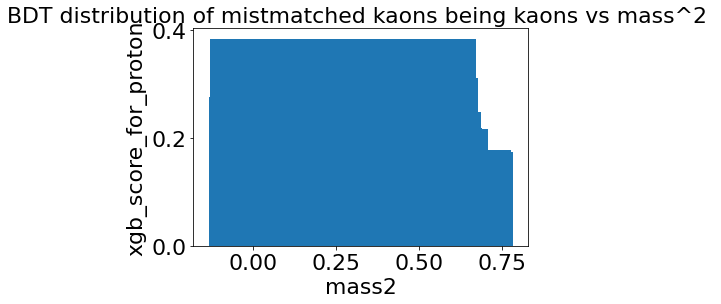

In [16]:
plt.bar(investigate_df["Complex_mass2"], investigate_df["model_output_1"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of mistmatched kaons being kaons vs mass^2 ")
plt.show()

In [17]:
protons = df[df["Complex_pid"] == 0].sample(10000)
kaons = df[df["Complex_pid"] == 1].sample(10000)

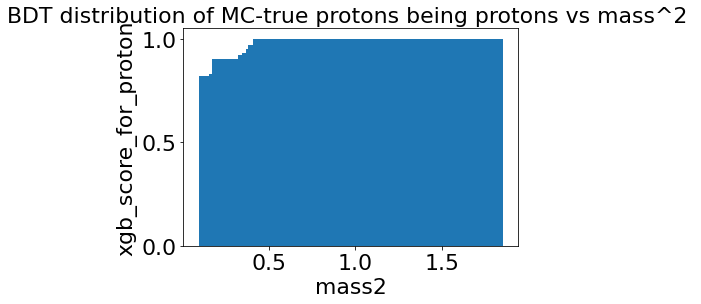

In [18]:
plt.bar(protons["Complex_mass2"], protons["model_output_0"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of MC-true protons being protons vs mass^2 ")
plt.show()

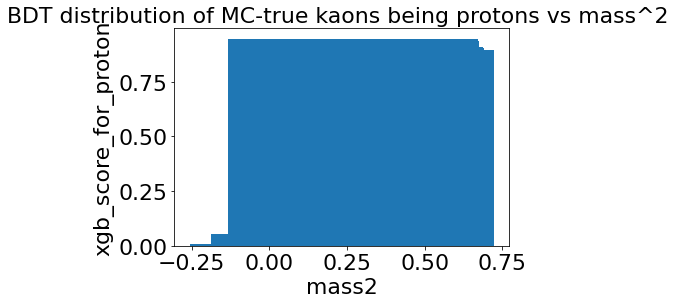

In [19]:
plt.bar(kaons["Complex_mass2"], kaons["model_output_0"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of MC-true kaons being protons vs mass^2 ")
plt.show()

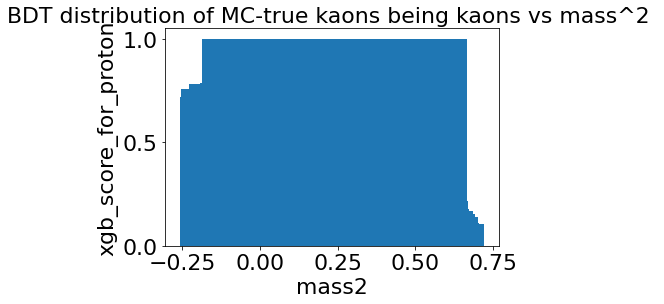

In [20]:
plt.bar(kaons["Complex_mass2"], kaons["model_output_1"])
plt.xlabel('mass2')  # Replace 'X-axis label' with an appropriate label for the x-axis
plt.ylabel('xgb_score_for_proton') 
plt.title("BDT distribution of MC-true kaons being kaons vs mass^2 ")
plt.show()